In [2]:
%config Completer.use_jedi = False


In [3]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc
import os
from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [4]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [31]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/normal'#modflow model
os.chdir(wdir)

In [8]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00189513, 0.11877509]])  # WA

csds_means = np.array([[0.120, 0.174, 0.112, 0.155, 0.066, 0.079],
                       [0.247, 0.333, 0.292, 0.212, 0.090, 0.127],
                       [0.309, 0.330, 0.244, 0.223, 0.120, 0.122],
                       [0.244, 0.269, 0.222, 0.251, 0.059, 0.107],
                       [0.220, 0.227, 0.160, 0.153, 0.078, 0.075],
                       [0.342, 0.385, 0.241, 0.481, 0.130, 0.130]])

csds_stds = np.array([[0.359, 0.356, 0.455, 0.399, 0.328, 0.452],
                      [0.986, 0.640, 0.497, 0.889, 0.275, 0.502],
                      [0.823, 0.683, 0.817, 0.819, 0.554, 0.782],
                      [0.312, 0.450, 0.444, 0.262, 0.378, 0.313],
                      [0.472, 0.415, 0.344, 0.363, 0.315, 0.599],
                      [0.542, 0.478, 0.386, 0.467, 0.450, 0.494]])




In [9]:
def plutonname(i):
    if i == 0:
        return 'Arizona'
    elif i == 1:
        return 'California East-West'
    elif i == 2:
        return 'California North-South'
    elif i == 3:
        return 'Guerrero'
    elif i == 4:
        return 'Montana'
    elif i == 5: 
        return 'Washington'
    

In [10]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Text(0.5, 1.0, 'mean grainsize per pluton')

Text(0, 0.5, 'grain size ()')

Text(0.5, 0, 'plutons')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

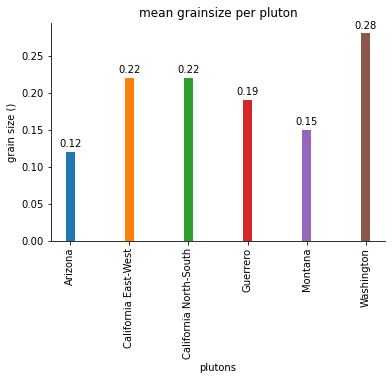

In [32]:

fig, ax = plt.subplots()
meangrainsizearr = []
plutonnames = []
for i in range(6):
    meangrainsize = np.mean(csds_means[i])
    meangrainsizearr.append(meangrainsize) 
    pluton = plutonname(i)
    plutonnames.append(pluton)
xas = np.arange(0,6,1)
rects = ax.bar(x = plutonnames , height = np.round(meangrainsizearr,2), width = 0.15, color = sns.color_palette())
autolabel(rects)

plt.title("mean grainsize per pluton")
plt.ylabel("grain size ()")
plt.xlabel("plutons")
plt.xticks(rotation ='vertical')
sns.despine()
plt.savefig("mean_grainsize_pluton.png")
plt.show()

In [11]:
def modalminplot(pluton, sedgen, name):
    fig, ax = plt.subplots()
    minerals_N_normalized = gen.normalize(sedgen.pr_minerals_N)
    rects = ax.bar(x = sedgen.pr_minerals, height=np.round(minerals_N_normalized, 2), color=sns.color_palette())
    autolabel(rects) 
    
    plt.title("parent rock total minerals normalised" + pluton )
    plt.ylabel("y", rotation=0, labelpad=10)

    sns.despine()
    plt.savefig("barplot_minerals_N_relative"+pluton+name+".png")
    plt.show();

In [12]:
def lineplotpcgmcg(pluton, sedgenmech, name):
    fig, ax = plt.subplots()
    ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
    ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)

    ax.text(70, 12, "mcg", color=sns.color_palette()[1], fontsize=12)
    ax.text(70, 2.5, "pcg", color=sns.color_palette()[0], fontsize=12)

    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.set_xlim(0, 77)
    ax.spines['bottom'].set_bounds(0, 77)
    ax.spines['left'].set_bounds(0, 14)
    ax.spines['left'].set_position(('outward', 10))
    # Set general tick parameters
    ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)
    ax.set_title(pluton)
    ax.set_xlabel("Timesteps", color='grey')
    ax.set_ylabel("$\log_{10}$n", rotation=0, labelpad=20, color='grey')
    # Set facecolor of figure
    plt.gcf().set_facecolor('white')
    sns.despine()
    # plt.legend()
    plt.tight_layout()
    plt.savefig('lineplot_pcgmcg_evolution_chem+mech' +name+ pluton +'.png')
    plt.show()

In [13]:
def lineplotchemweath(pluton, sedgenchem, sedgen, name):
    fig, ax = plt.subplots() 

    for i in range(6):
        ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
    
    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(0, 100)
    ax.set_ylim(4.5, 8.5)

    ax.spines['bottom'].set_bounds(0, 100)
    ax.spines['left'].set_bounds(4.5, 8.5)

    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)
    ax.set_title("residue " + pluton)
    ax.set_xlabel("Timesteps", color='grey')
    ax.set_ylabel("$\log_{10}$V", rotation=0, labelpad=20, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("lineplot_volume_residue_chem+mech"+name+pluton+".png")
    plt.show();


In [41]:
def barplotvolumepergrainsize(pluton, sedgenweath, name, nsteps = 99):
    fig, ax = plt.subplots()

    for d in range(0, 1500, 25):
        heights = np.zeros(6)
        for m in range(6):
            csd_filter = sedgenweath.pcg_crystal_sizes[0][sedgenweath.pcg_crystals[0] == m]
            chem_state_filter = sedgenweath.pcg_chem_weath_states[0][sedgenweath.pcg_crystals[0] == m]

            csd_filter_filtered = csd_filter[np.where((d <= csd_filter) & (csd_filter < d+25))]
            chem_state_filter_filtered = chem_state_filter[np.where((d <= csd_filter) & (csd_filter < d+25))]
            heights[m] = np.sum(sedgenweath.volume_bins_medians_matrix[chem_state_filter_filtered, 0, csd_filter_filtered])
            if d == 600:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
            else:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)

    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(-10, 5)
    ax.set_ylim(0, 2e7)

    ax.spines['bottom'].set_bounds(-10, 5)
    ax.spines['left'].set_bounds(0, 2e7)

    ax.spines['left'].set_position(('outward', 10))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)
    
    ax.set_title("pcg chemical weathering " + pluton)
    ax.set_xlabel("Phi-scale", color='grey')
    ax.set_ylabel("V", rotation=0, labelpad=20, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("barplot_volume_pcg_xx_"+name+pluton+".png")
    plt.show();

In [42]:
def barplotvolume(pluton, sedgenweath, name):
    fig, ax = plt.subplots()

    for d in range(0, 1500, 25):
        heights = np.sum(sedgenweath.mcg[0, :, d:d+25] * sedgenweath.volume_bins_medians_matrix[0, :, d:d+25], axis=1)
        if d == 750:
            print(heights)
        for m in range(6):
            if d == 600:
                ax.bar(np.log2(sedgenweath.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
            else:
                ax.bar(np.log2(sedgenweath.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])


    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(-10, 5)
    ax.set_ylim(0, 2e7)

    ax.spines['bottom'].set_bounds(-10, 5)
    ax.spines['left'].set_bounds(0, 2e7)

    ax.spines['left'].set_position(('outward', 10))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)
    
    ax.set_title("mechanical weathering mcg grains " + pluton )
    ax.set_xlabel("Phi-scale", color='grey')
    ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("barplot_volume_mcg_mech_CA-NS" + name + pluton + ".png")
    plt.show();
    

In [49]:
def barplotvolumebothoper(pluton, sedgenweath, name, nsteps = 99):
    fig, ax = plt.subplots()

    for d in range(0, 1500, 25):
        heights = np.sum(np.sum(sedgenweath.mcg[:, :, d:d+25] * sedgenweath.volume_bins_medians_matrix[:, :, d:d+25], axis=0), axis=1)
        for m in range(6):
            if d == 600:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
            else:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)


    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(-10, 5)
    ax.set_ylim(0, 1e7)

    ax.spines['bottom'].set_bounds(-10, 5)
    ax.spines['left'].set_bounds(0, 1e7)

    ax.spines['left'].set_position(('outward', 10))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)
    ax.set_title("mech and chem weathering mcg grains " + pluton)
    ax.set_xlabel("Phi-scale", color='grey')
    ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("barplot_volume_mcg_both_CA-NS" + name + pluton + ".png")
    plt.show();

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
[0.16331256 0.46387757 0.12683457 0.05758711 0.01078412 0.17760407]


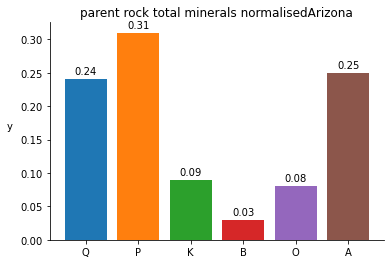

After 86 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


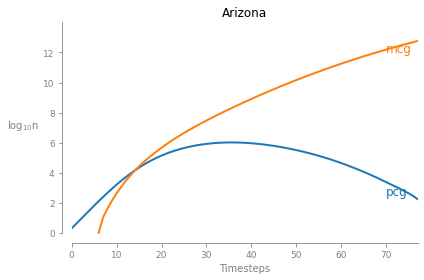

[ 575681.29559083 2169415.38830082  643194.06450702  287439.9346238
   55008.2550034   788556.02755527]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


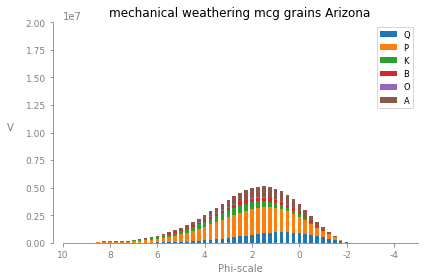

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

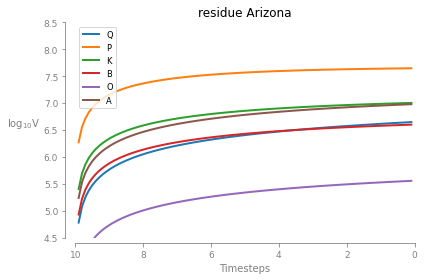

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


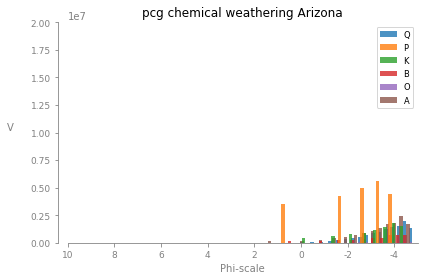

After 67 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


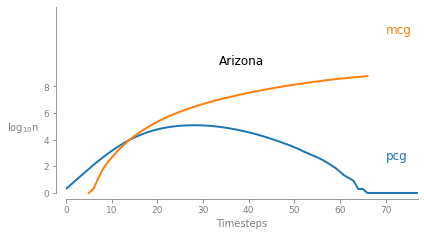

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

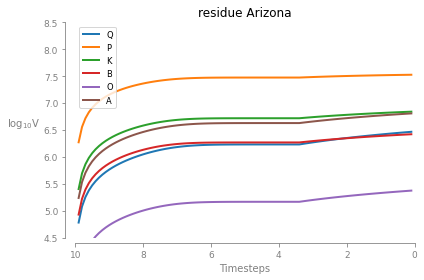

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


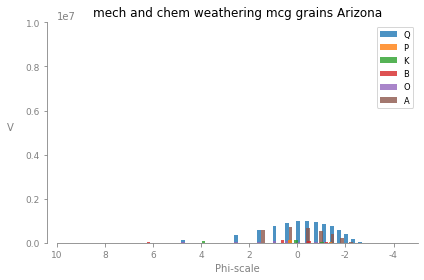

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
too few P -2
too few K -2
too few B -1
too few O -3
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
[0.27453254 0.40124204 0.24993859 0.02509231 0.00454988 0.04464465]


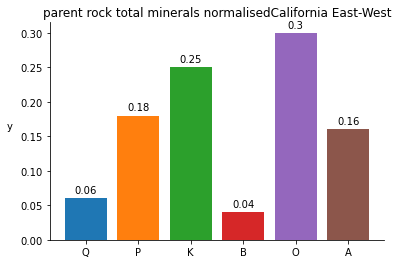

After 72 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


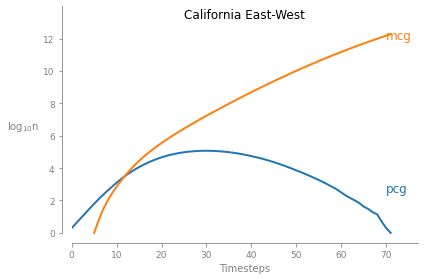

[ 275120.05911638 1126872.16789151 1031409.7516941   359504.38504331
   19987.1496215   138426.57870186]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


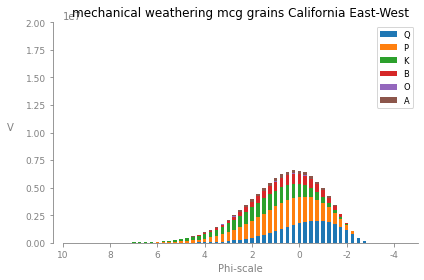

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

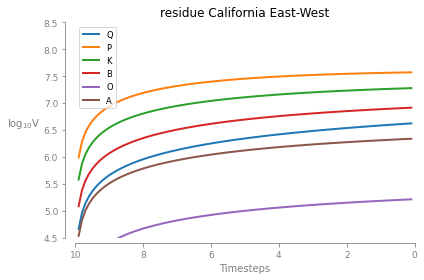

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


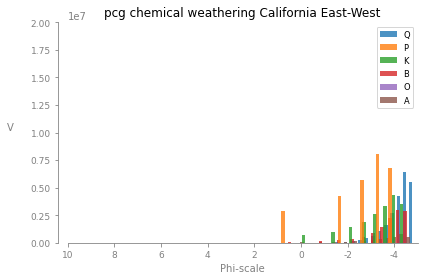

After 54 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


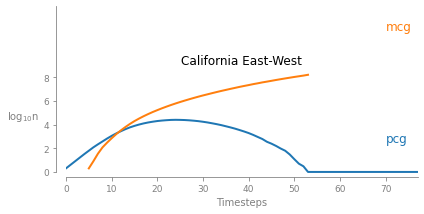

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

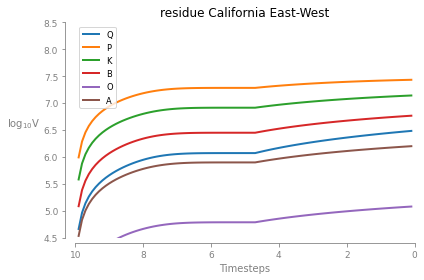

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


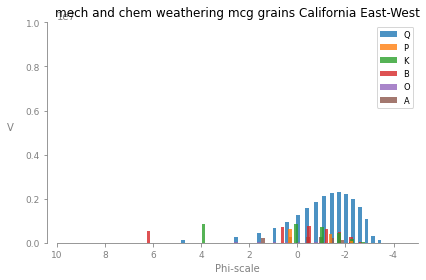

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
[0.30591989 0.38159713 0.26209888 0.0188256  0.00799247 0.02356603]


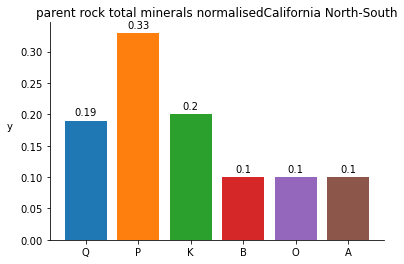

After 69 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


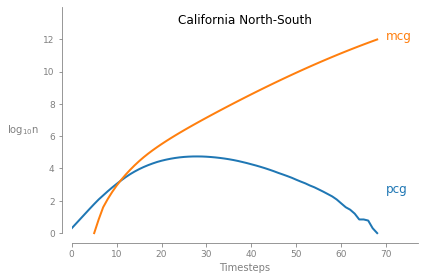

[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


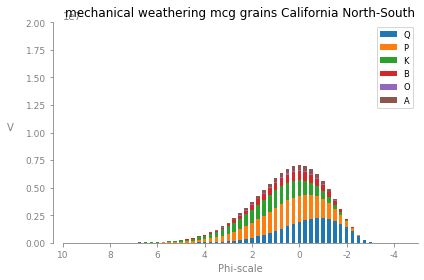

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

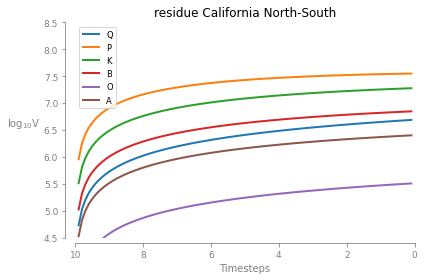

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


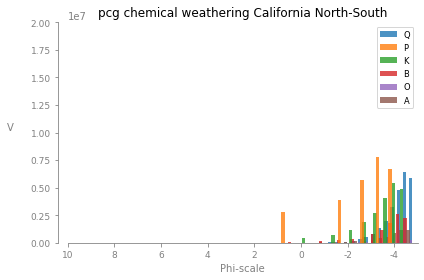

After 56 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


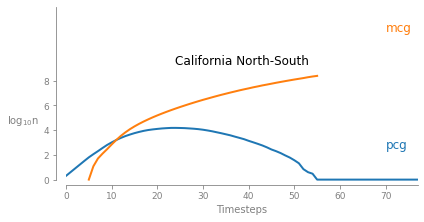

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

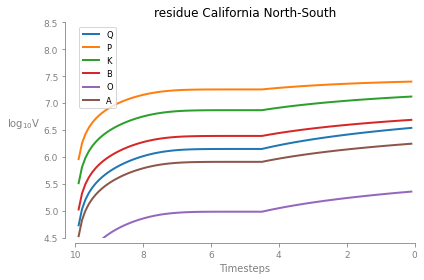

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


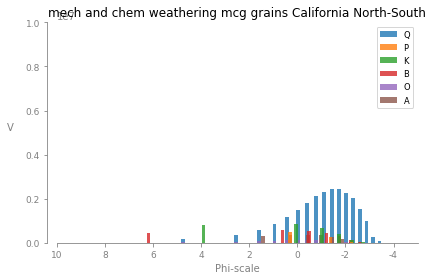

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
all good P 0
too much K 1
too few B -1
too few O -3
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
[0.19781274 0.41766034 0.16121575 0.06478527 0.00894429 0.14958161]


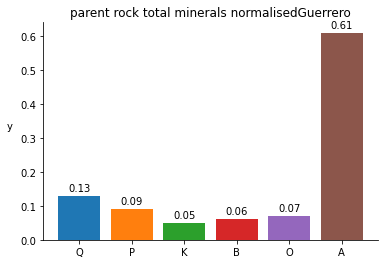

After 89 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


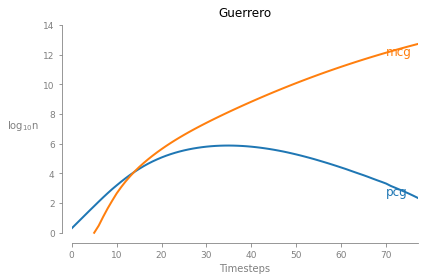

[ 796365.54563015 2079360.93276928  797997.53163764  335702.9163968
   50935.46692333  736995.13011036]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


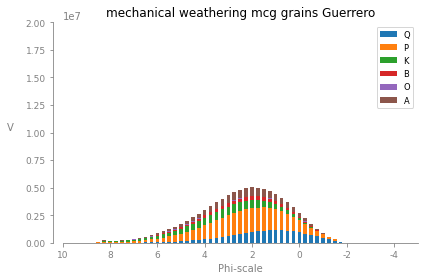

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

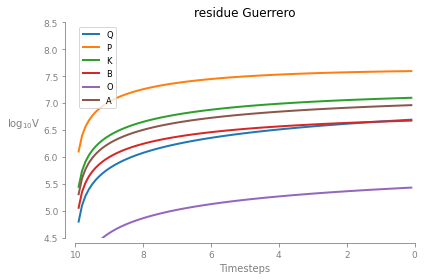

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


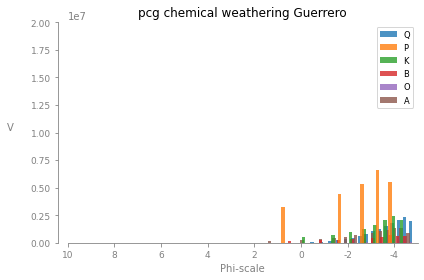

After 65 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


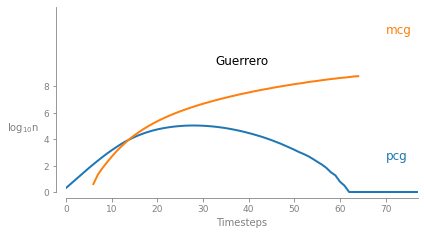

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

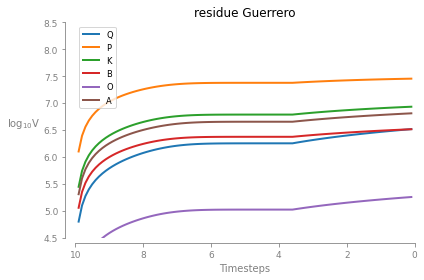

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


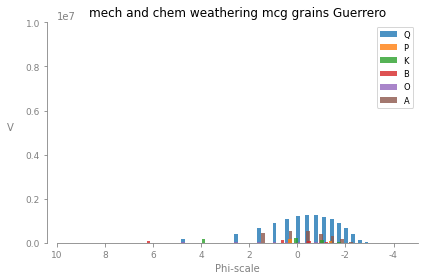

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 25
too few P -7
too few K -8
too few B -3
too few O -4
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
[0.25983144 0.46392506 0.15827298 0.04370113 0.00689158 0.06737782]


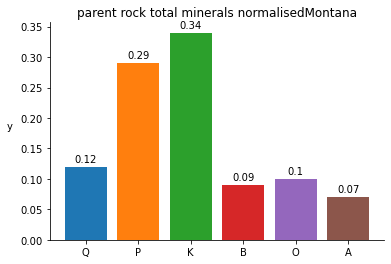

After 79 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


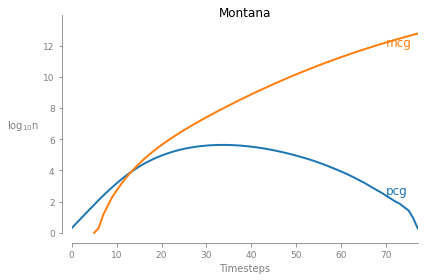

[ 497270.20130193 1755820.21318636  762540.84757123  187101.625975
   30227.5359525   236891.47237899]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


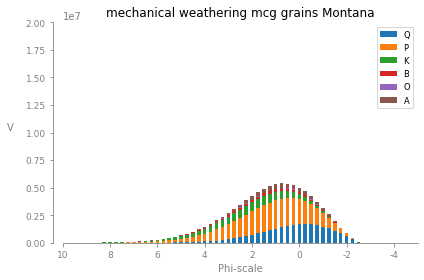

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

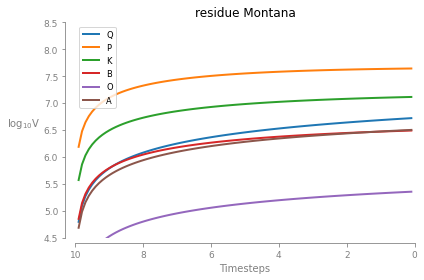

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


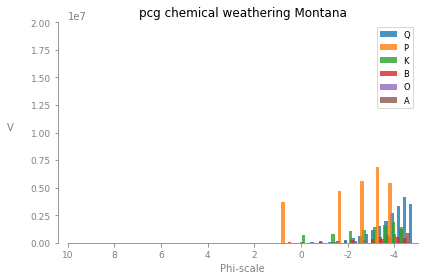

After 64 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


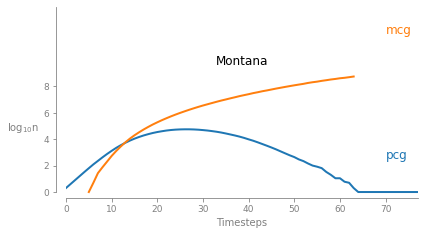

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

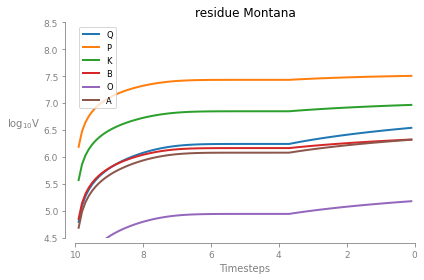

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


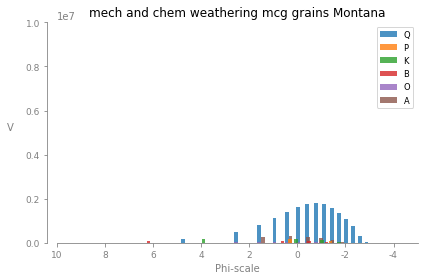

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 8
too few P -2
all good K 0
all good B 0
too few O -1
too few A -5
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
[0.22419158 0.48490082 0.05641885 0.11571367 0.00189513 0.11877509]


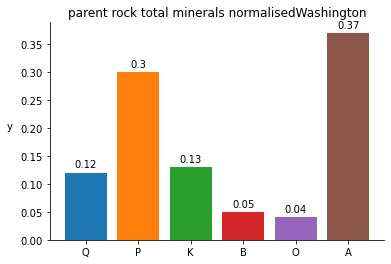

After 74 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


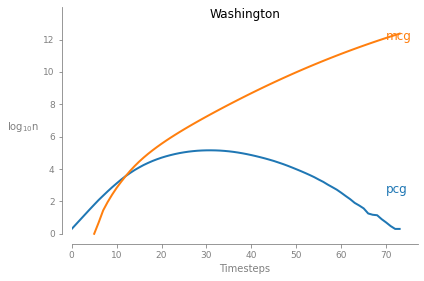

[ 328020.02651862 1597566.94318039  279312.2280107   377388.32550327
   32192.9747089   378225.54711758]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


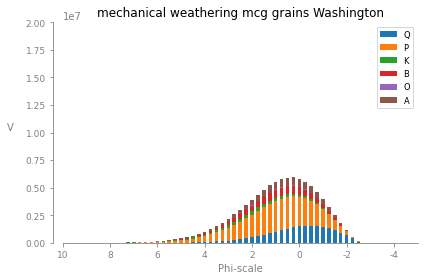

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

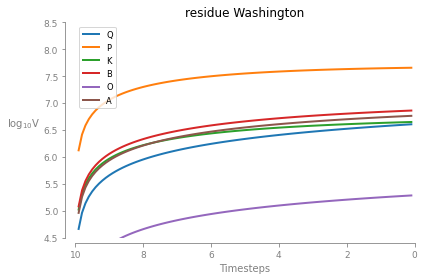

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


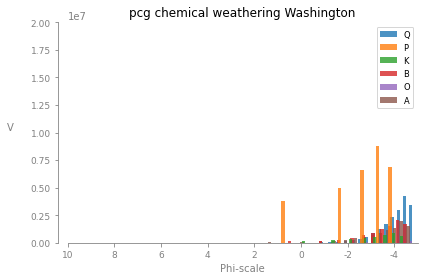

After 61 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


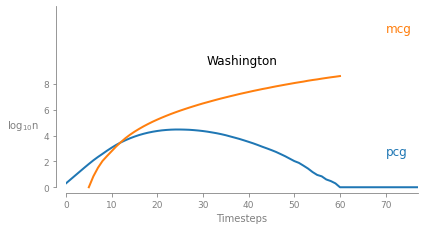

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

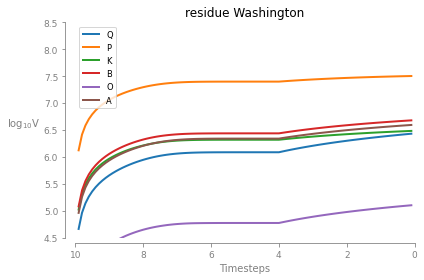

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


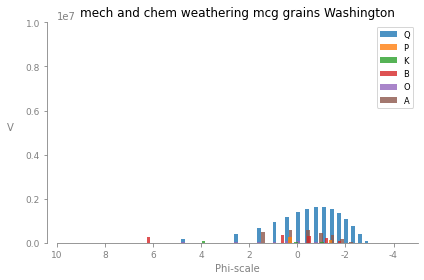

Wall time: 26min 29s


In [34]:
%%time
for i in range (6): #voor alle plutons
#for i in ([2]): #testen bij slechts 1 pluton  
    #sedgen running for every pluton
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], csds_means[i], csds_stds[i],
                    learning_rate = 1000,
                    auto_normalize_modal_mineralogy = True,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03])
    print(modal_mineralogy[i])
        #establishing plutonname
    pluton = plutonname(i)
    modalminplot(pluton, sedgen, "sedgen")
    
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech")
    barplotvolume(pluton, sedgen_mech, "sedgen_mech")
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem")
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem")

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech")
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech")
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech")
    

In [16]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/new_input'#modflow model
os.chdir(wdir)

In [17]:
# Create scenario data
balance = np.array([0.5] * 100)
climate = np.array([2] * 100)
# Keep additional input material limited to first couple of steps
# Otherwise this has a massive performance impact regarding the time it
# takes for the model to execute due to very high number of pcgs/mcgs.
new_input = np.array([0.01] * 10 + [0.0] * 90)

scenario_array = np.stack([balance, climate, new_input], axis=1)



---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


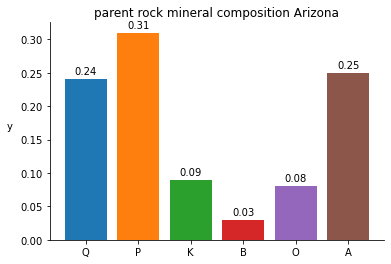

After 86 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


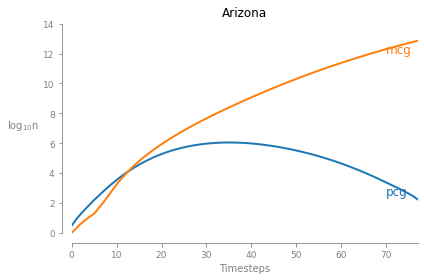

[ 644635.7919381  2387974.9760826   699247.61365211  316843.36184589
   61948.06838978  866645.34299748]


<ipython-input-14-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


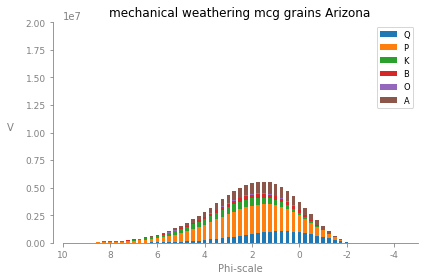

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

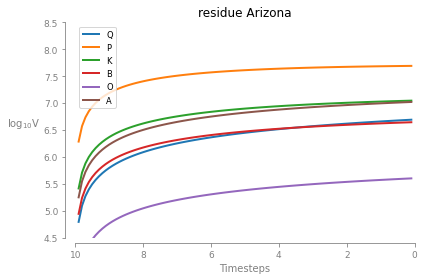

<ipython-input-13-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


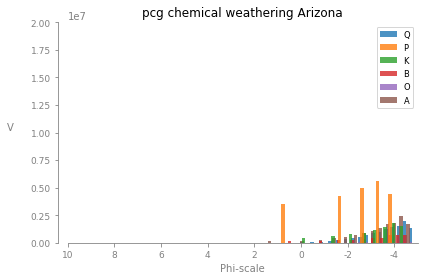

After 67 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


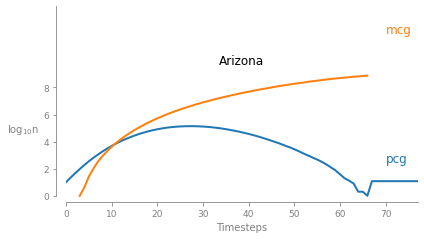

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

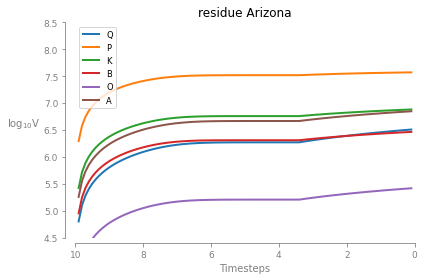

<ipython-input-15-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


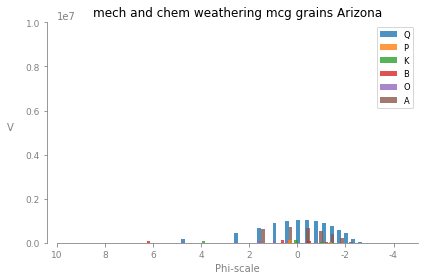

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
too few P -2
too few K -2
too few B -1
too few O -3
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


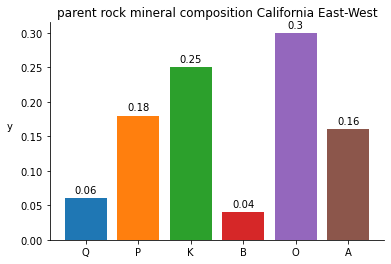

After 72 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


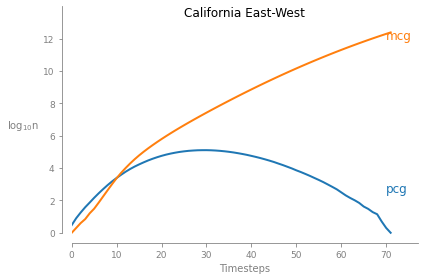

[ 323963.08767043 1283513.40589396 1153422.24457968  410595.50273514
   22464.93975974  157393.59424956]


<ipython-input-14-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


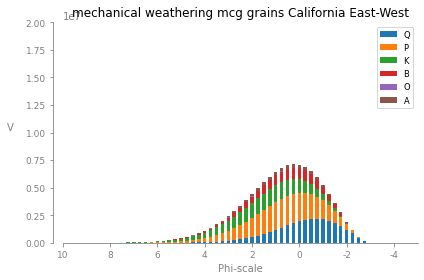

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

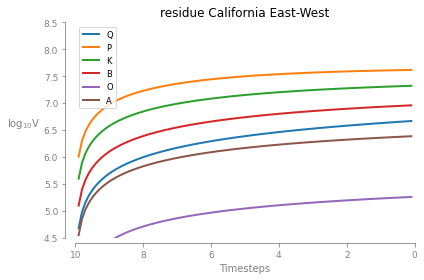

<ipython-input-13-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


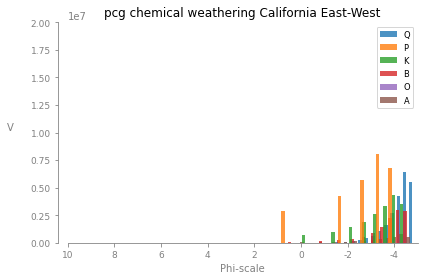

After 54 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


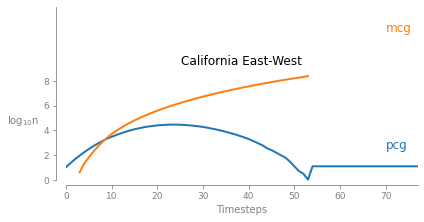

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

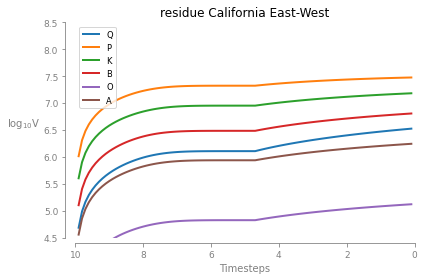

<ipython-input-15-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


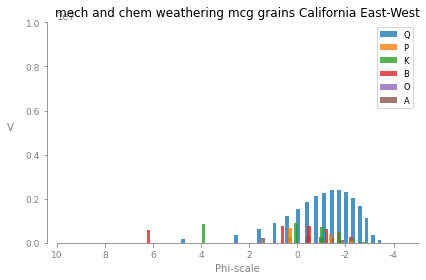

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


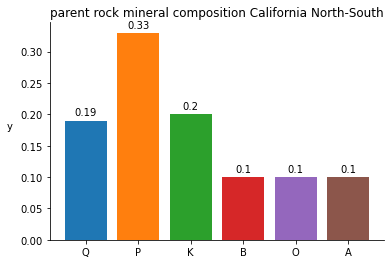

After 69 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


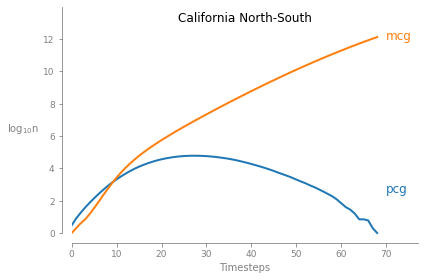

[ 319614.88637092 1111146.52180388 1091890.48650051  331823.84454863
   47579.26634322  168573.87890754]


<ipython-input-14-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


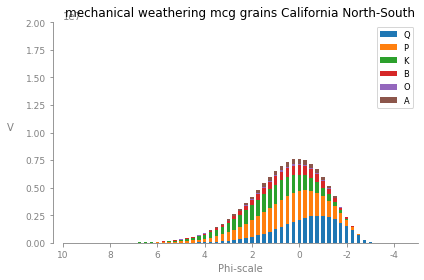

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

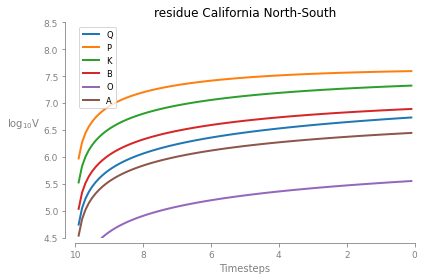

<ipython-input-13-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


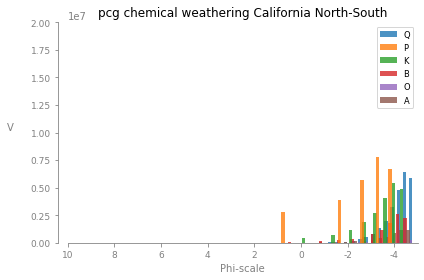

After 56 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


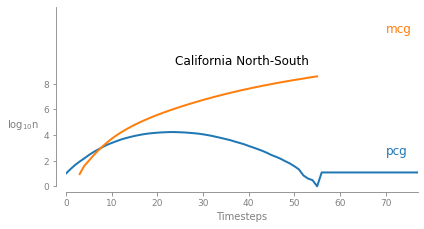

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

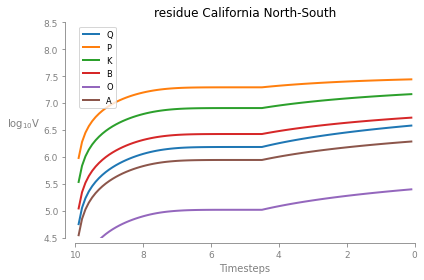

<ipython-input-15-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


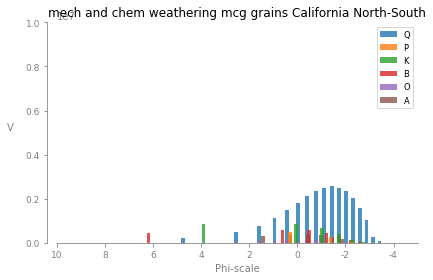

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
all good P 0
too much K 1
too few B -1
too few O -3
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


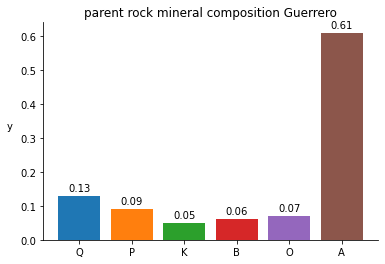

After 89 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


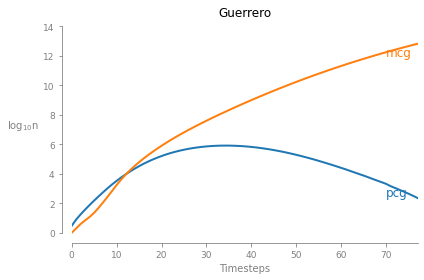

[ 885416.44370667 2292226.99595826  865769.57559963  370065.00650547
   57364.06346061  806610.22531296]


<ipython-input-14-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


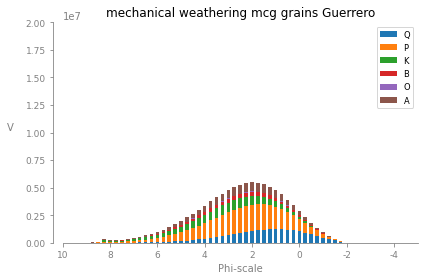

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

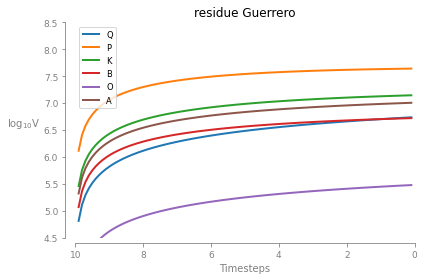

<ipython-input-13-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


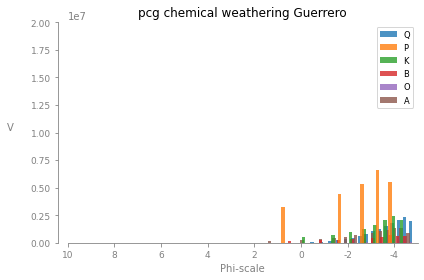

After 65 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


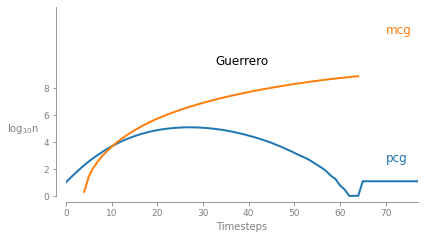

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

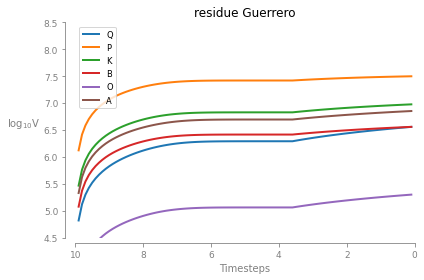

<ipython-input-15-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


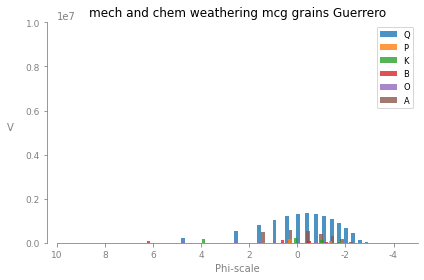

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 25
too few P -7
too few K -8
too few B -3
too few O -4
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


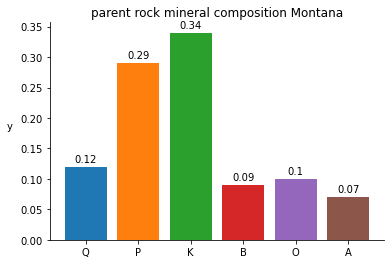

After 79 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


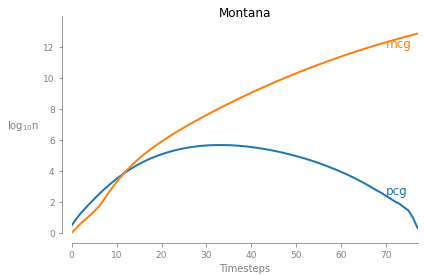

[ 565039.70743798 1970980.84924284  835518.43127816  209404.04959769
   34251.26905132  265177.28053988]


<ipython-input-14-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


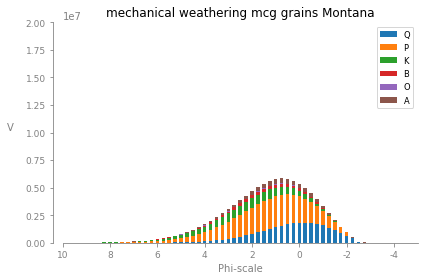

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

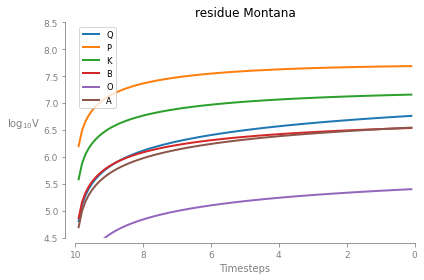

<ipython-input-13-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


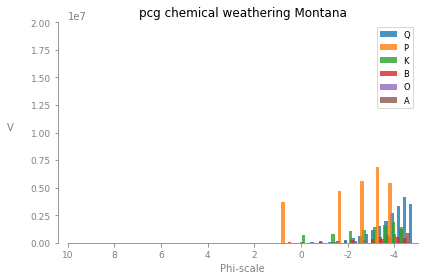

After 64 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


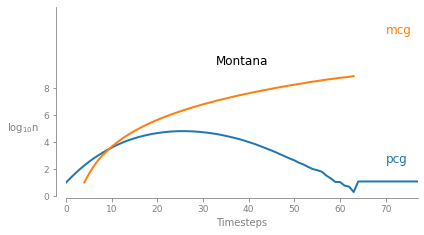

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

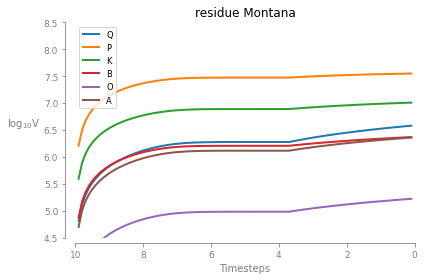

<ipython-input-15-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


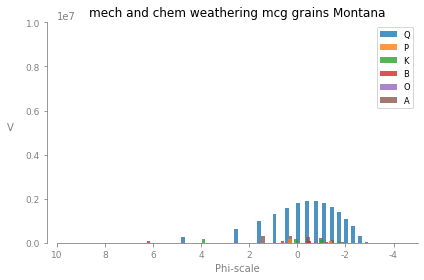

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 3
all good P 0
all good K 0
all good B 0
too few O -2
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


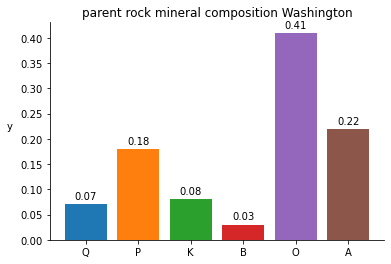

After 79 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


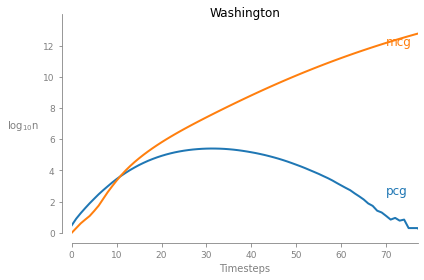

[ 566782.5495457  2284882.45617899  335536.7624793   556996.34498924
       0.          532348.55181722]


<ipython-input-14-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


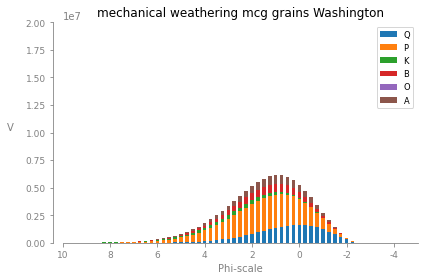

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

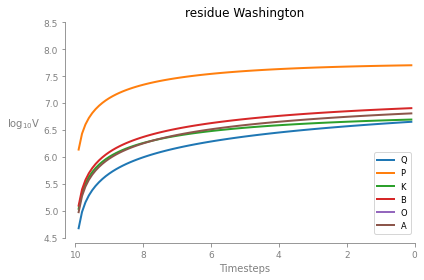

<ipython-input-13-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


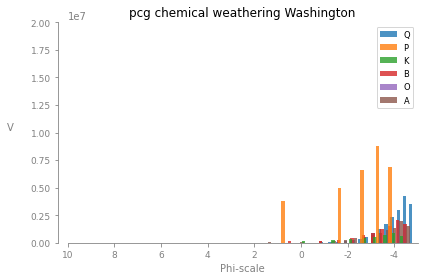

After 61 steps all pcgs have been broken down to mcg


<ipython-input-11-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


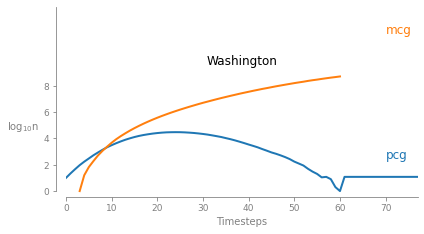

<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-12-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

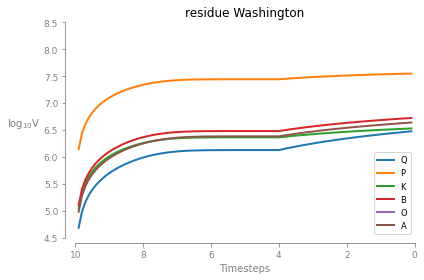

<ipython-input-15-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-15-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


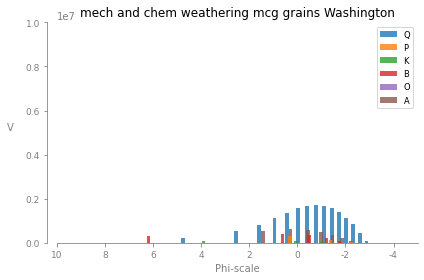

Wall time: 32min 17s


In [18]:
%%time
for i in range (6): #voor alle plutons
#for i in ([2]): #testen bij slechts 1 pluton  
    #sedgen running for every pluton
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], csds_means[i], csds_stds[i],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    scenario_data = scenario_array)
        #establishing plutonname
    pluton = plutonname(i)
    name_addition = "new_input"
    modalminplot(pluton, sedgen, "sedgen" + name_addition)
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech" + name_addition)
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + name_addition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem" + name_addition)
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + name_addition)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)

Now investigate balance between mechanical and chemical weathering using scenario_data as input
use of CA_NS pluton


In [29]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/balance'#modflow model
os.chdir(wdir)

In [30]:
# Create scenario data
def createscenariodata(balans,climate,newinput):
    balance = np.array([balans] * 100)
    climate = np.array([climate] * 100)
    # Keep additional input material limited to first couple of steps
    # Otherwise this has a massive performance impact regarding the time it
    # takes for the model to execute due to very high number of pcgs/mcgs.
    new_input = np.array([newinput] * 10 + [0.0] * 90)

    scenario_array = np.stack([balance, climate, new_input], axis=1)
    return scenario_array

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


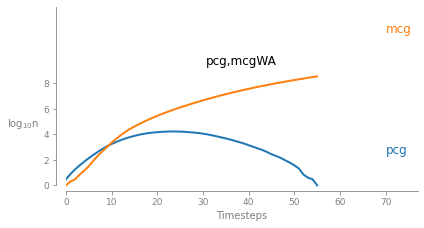

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

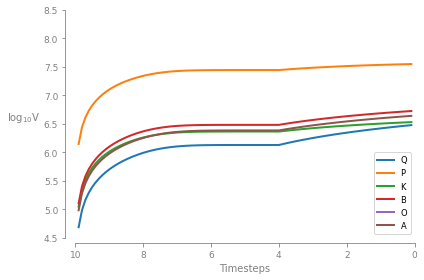

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


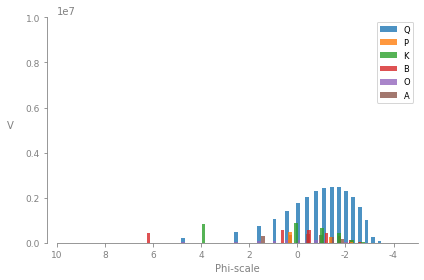

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


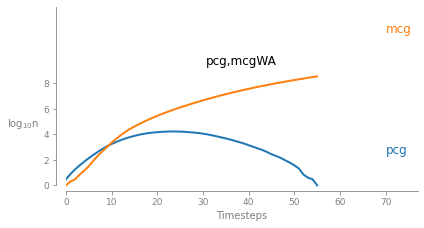

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

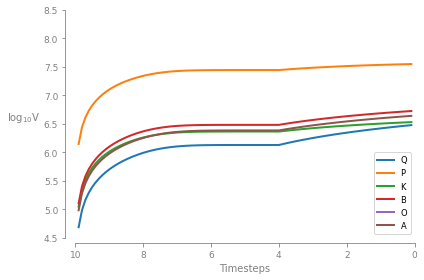

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


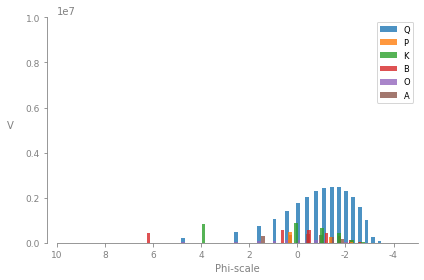

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


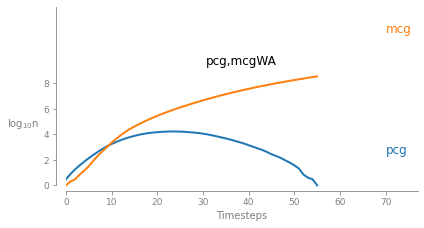

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

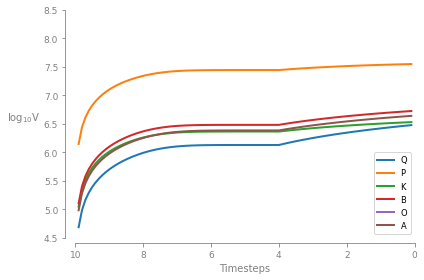

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


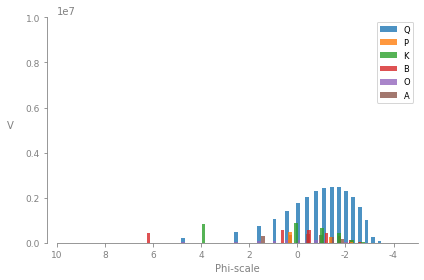

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


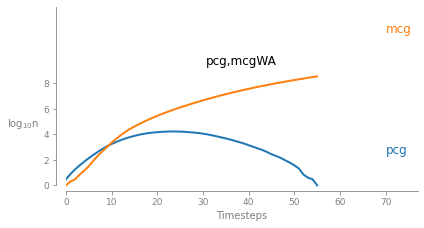

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

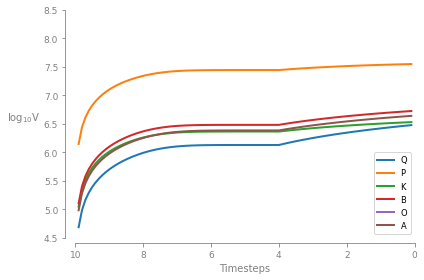

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


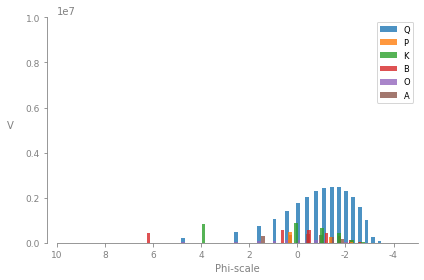

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


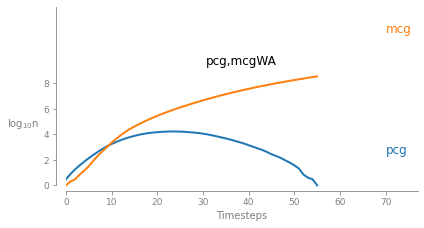

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

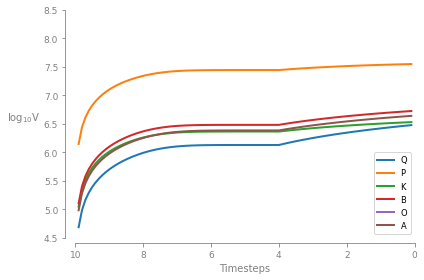

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


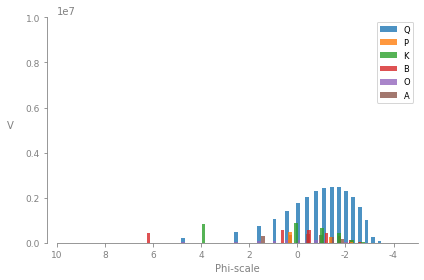

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


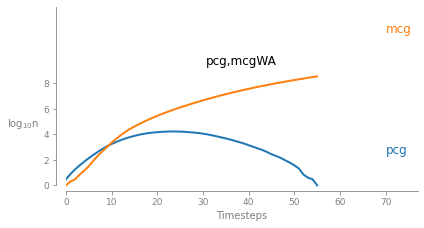

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

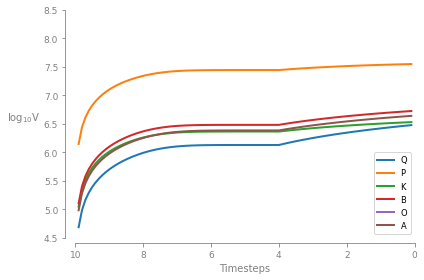

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


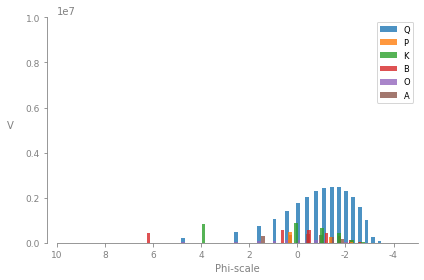

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


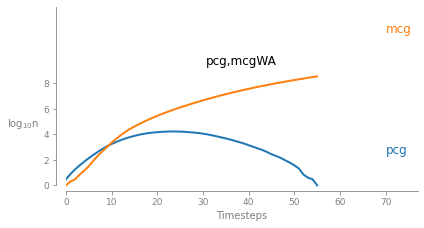

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

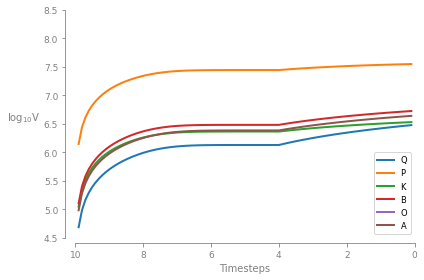

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


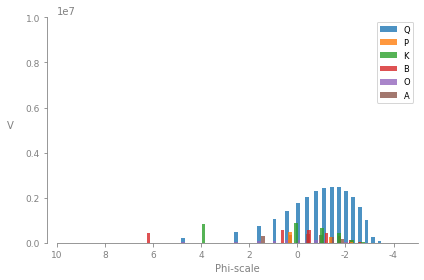

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


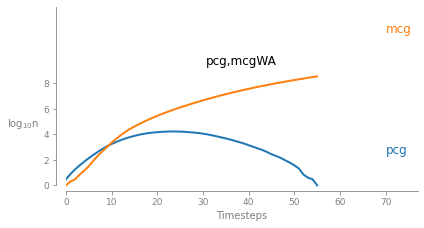

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

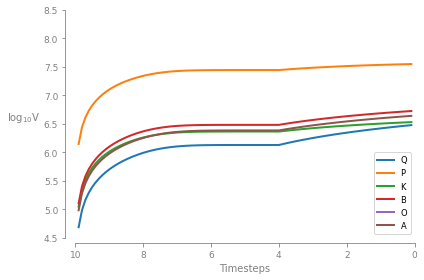

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


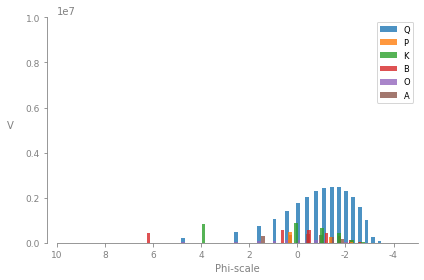

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


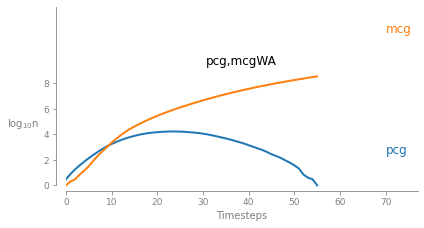

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

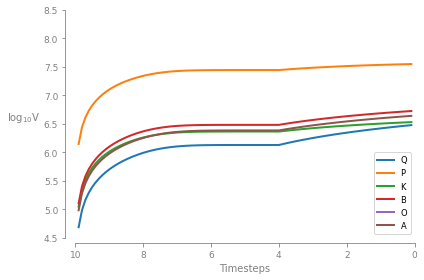

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


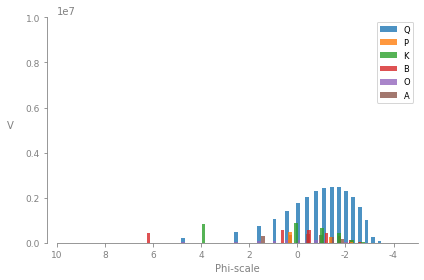

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


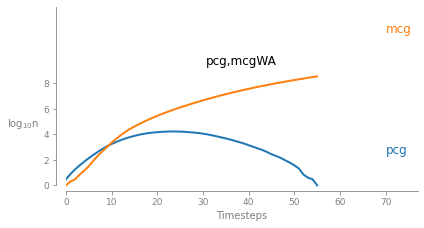

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

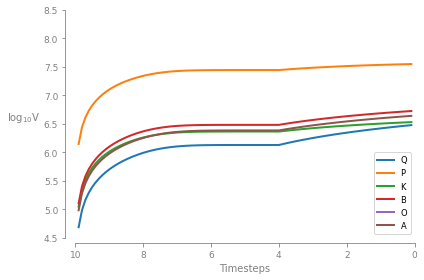

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


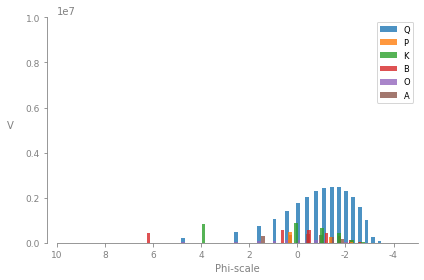

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


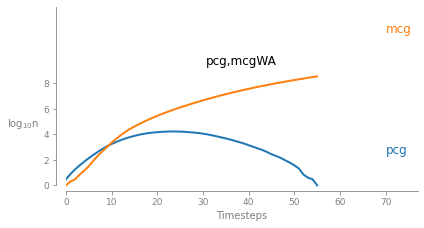

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

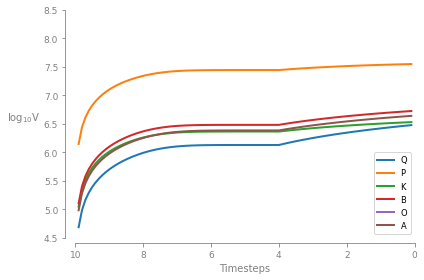

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


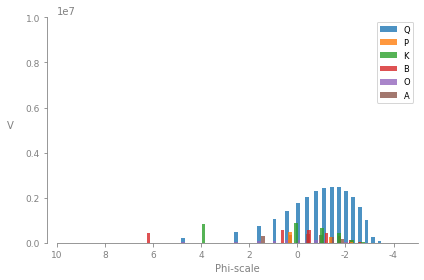

In [31]:
balanslist = np.arange(0, 1.1, 0.1, dtype = float)
print(balanslist)
climate = 2
newinput = 0.01
for i in balanslist:
    balance = i
    scenario_array = createscenariodata(balance, climate, newinput)
    #model
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[2], csds_means[2], csds_stds[2],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    scenario_data = scenario_array)
    
    #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    balancename = str(i)
    name_addition = "balance" + balancename
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)

    

variation of grain size with modal mineralogy cst:
we nemen telkens een vaste modale mineralogy (CA_NS)
we beginnen met grain sizes van mineralen (CA_NS)
5 keer grain size met 10% verminderen, 5 keer initiele grain size met 10% vermeerderen

In [17]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/grain_size_variation'#modflow model
os.chdir(wdir)

[0.309 0.33  0.244 0.223 0.12  0.122]
[0.1545 0.165  0.122  0.1115 0.06   0.061 ]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
too few P -1
too much K 1
too few B -1
too much O 1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


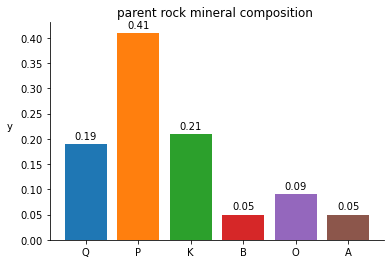

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


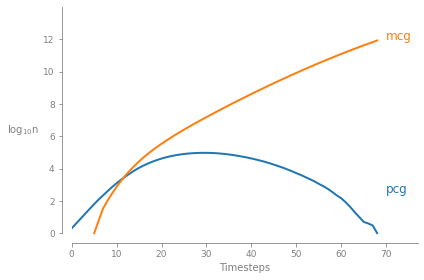

[244175.68946636 887650.41036754 874725.07051816 151701.65958702
  20096.26433287  69920.26460249]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


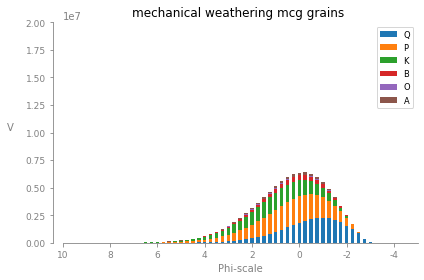

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

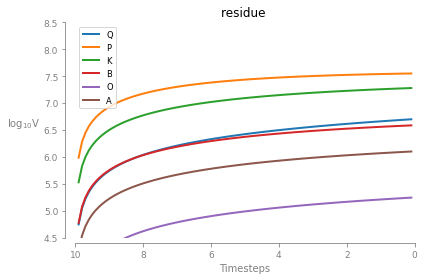

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


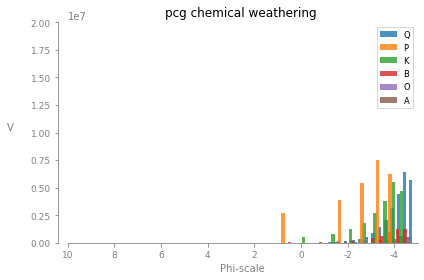

After 59 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


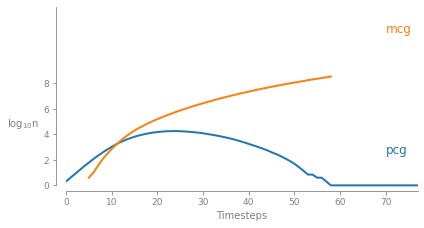

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

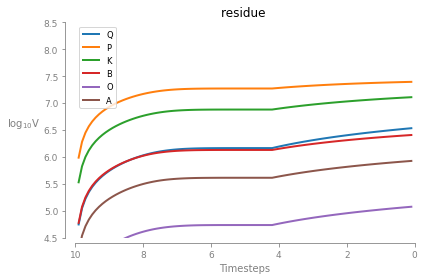

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


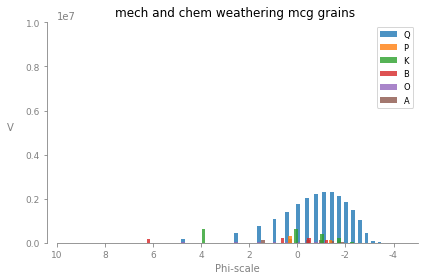

[0.1854 0.198  0.1464 0.1338 0.072  0.0732]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
all good P 0
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


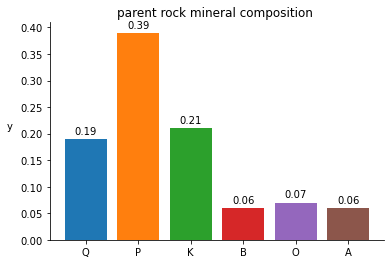

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


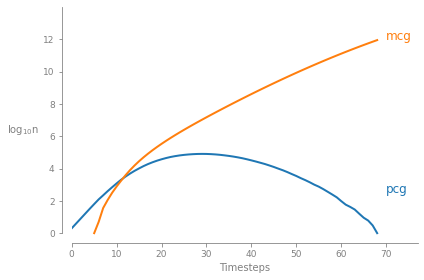

[254359.8637861  910216.24719965 907066.3116908  181285.99481411
  24903.38333348  87382.0962246 ]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


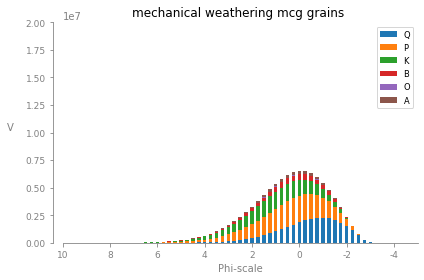

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

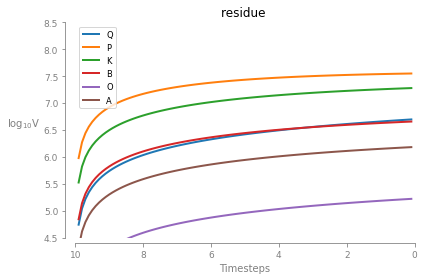

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


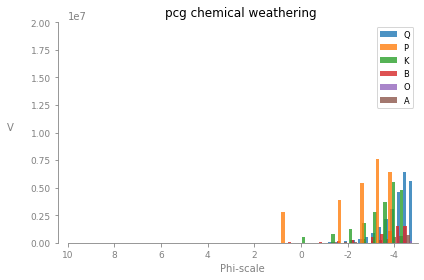

After 63 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


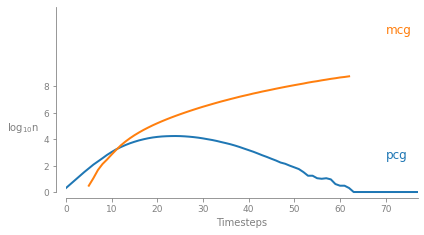

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

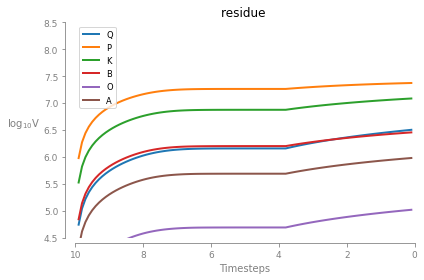

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


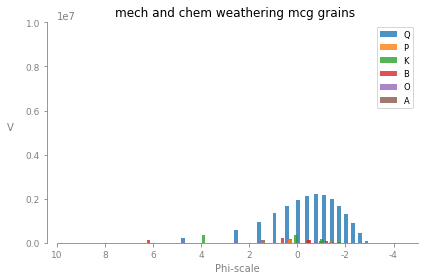

[0.2163 0.231  0.1708 0.1561 0.084  0.0854]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 7
too few P -3
too much K 1
too few B -1
too few O -3
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


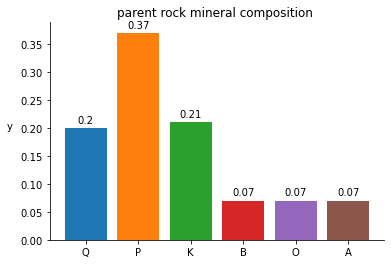

After 70 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


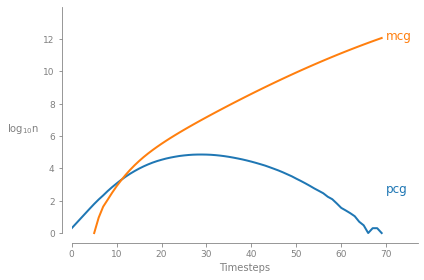

[ 295809.96414363 1020513.54627434  994268.46265811  235303.69890186
   29237.80392392  109528.03851819]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


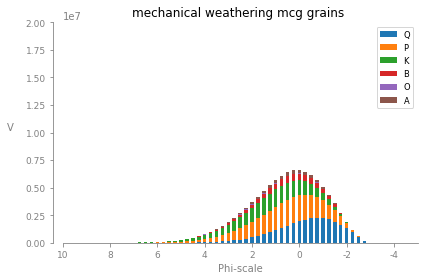

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

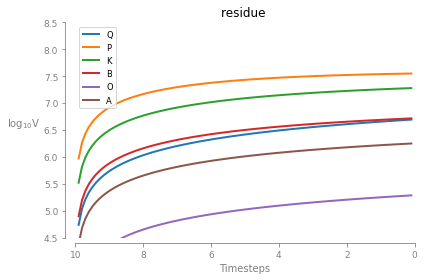

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


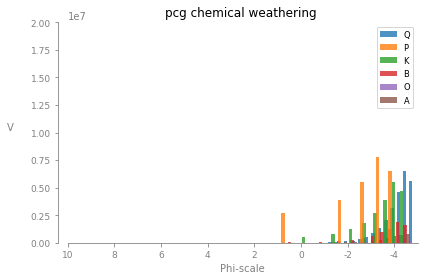

After 55 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


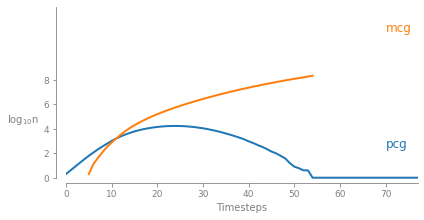

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

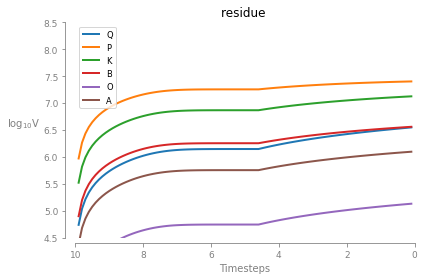

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


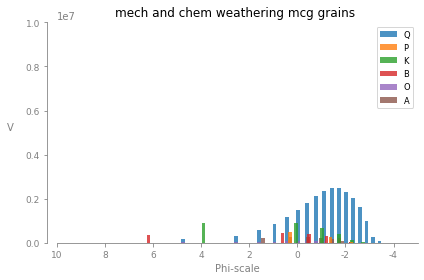

[0.2472 0.264  0.1952 0.1784 0.096  0.0976]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 4
too much P 1
too few K -2
too few B -1
too few O -1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


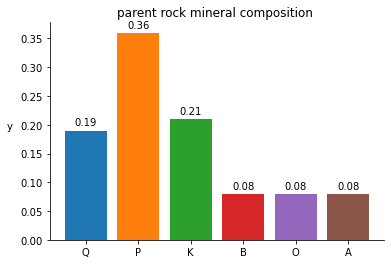

After 70 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


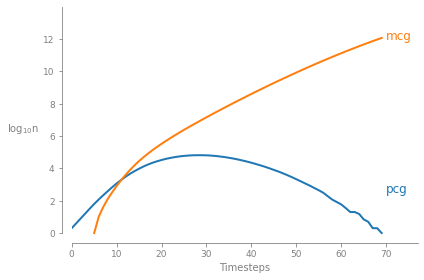

[ 301324.18731659 1036949.18017444 1010924.69941988  259944.45983249
   33886.70474318  124335.59485269]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


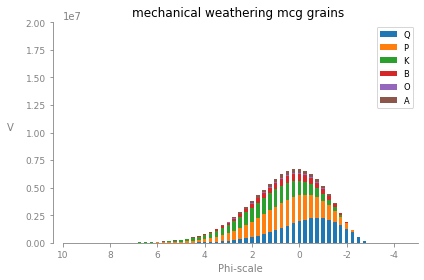

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

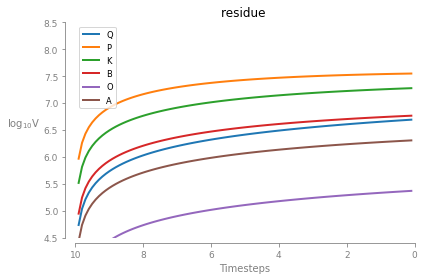

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


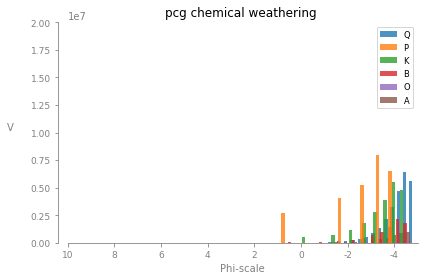

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


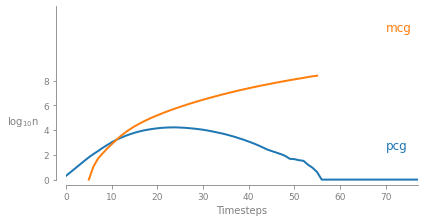

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

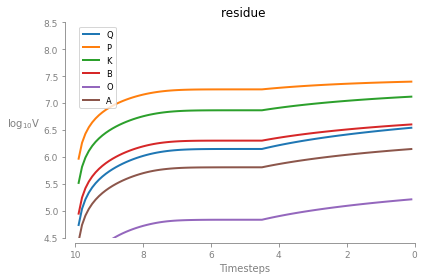

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


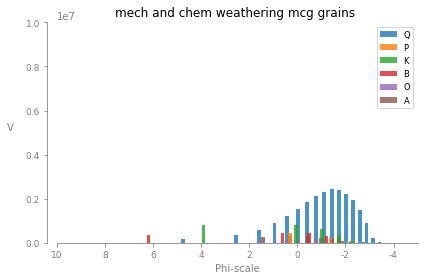

[0.2781 0.297  0.2196 0.2007 0.108  0.1098]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 10
too few P -4
too few K -1
too few B -1
too few O -2
too few A -2
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


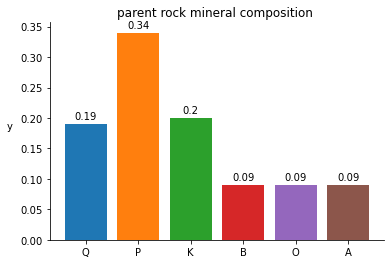

After 76 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


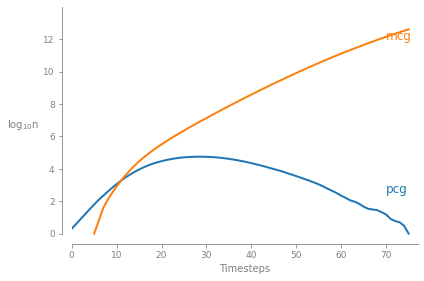

[ 535997.29663201 1491597.03291479 1270770.45531109  421818.09625643
   57396.71167725  212468.13461959]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


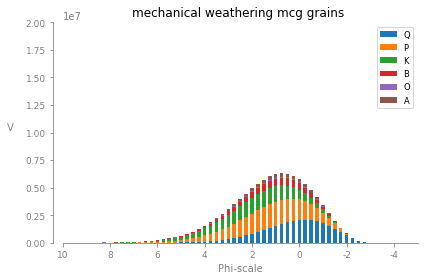

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

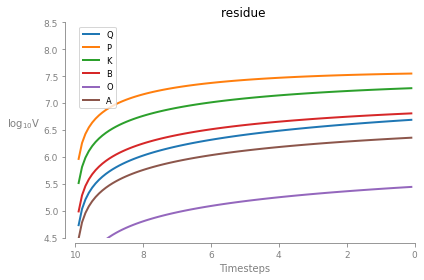

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


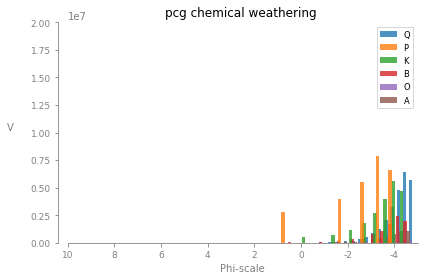

After 59 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


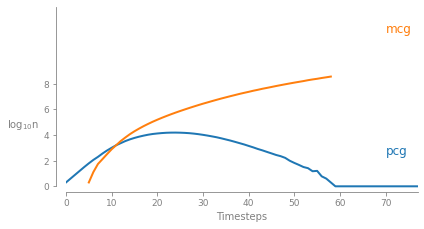

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

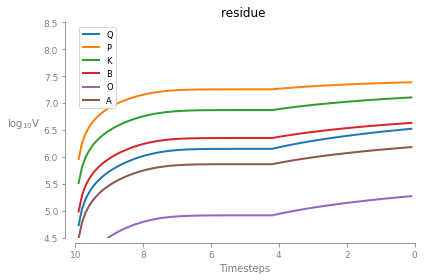

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


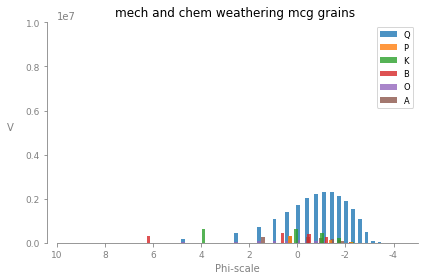

[0.309 0.33  0.244 0.223 0.12  0.122]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


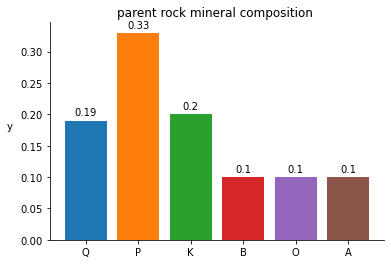

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


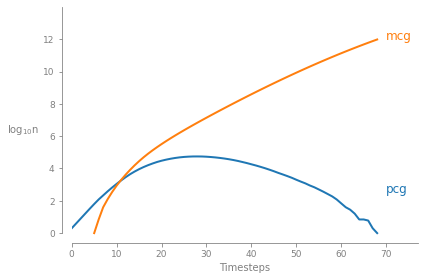

[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


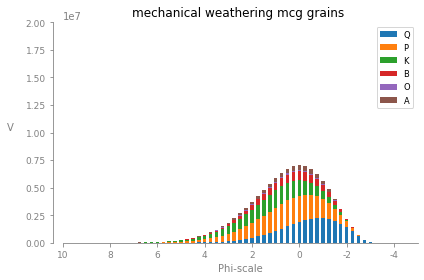

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

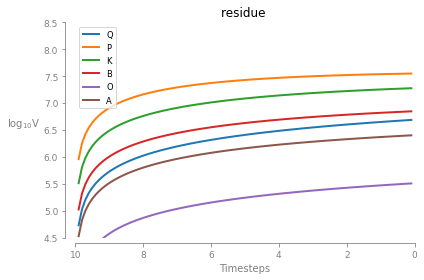

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


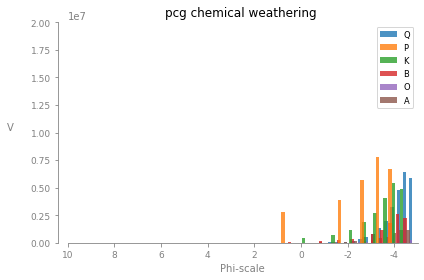

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


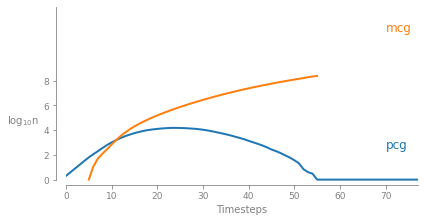

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

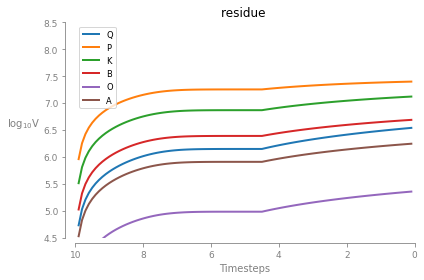

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


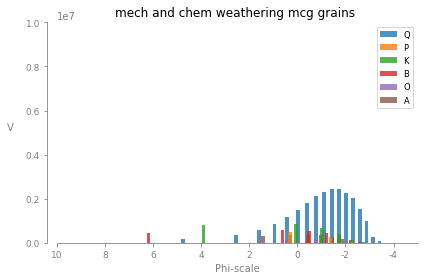

[0.3399 0.363  0.2684 0.2453 0.132  0.1342]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 8
too few P -3
too few K -2
too few B -2
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


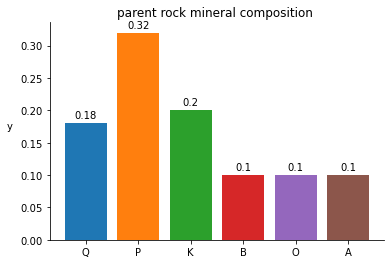

After 68 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


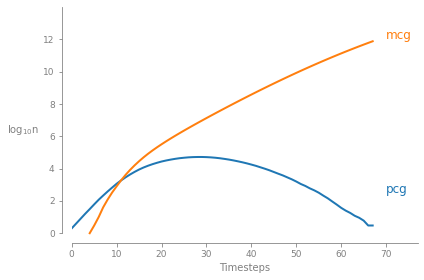

[240224.48350002 880536.47155376 887294.41754954 279615.41873514
  41384.14365629 136081.87776494]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


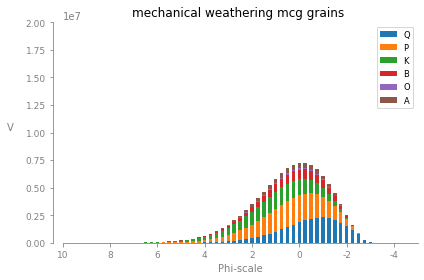

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

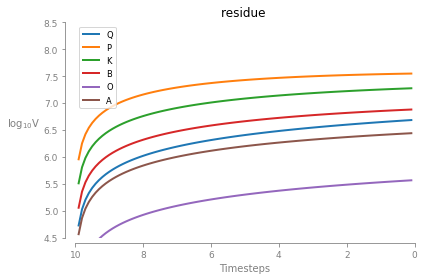

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


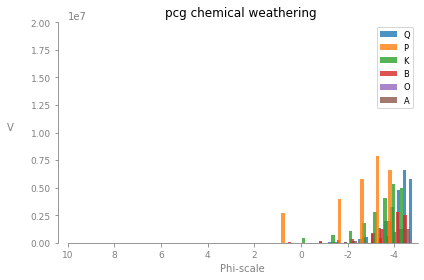

After 54 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


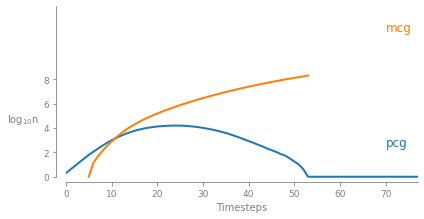

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

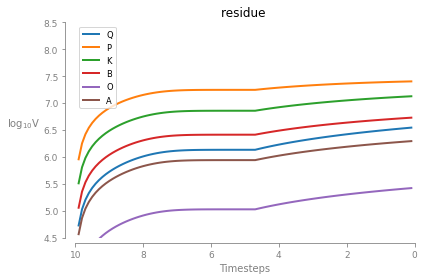

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


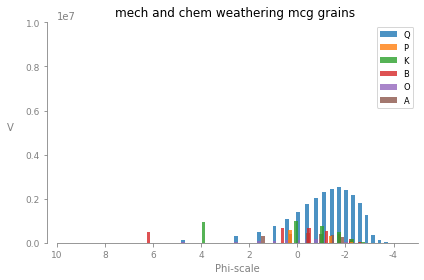

[0.3708 0.396  0.2928 0.2676 0.144  0.1464]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 3
too much P 1
too few K -4
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


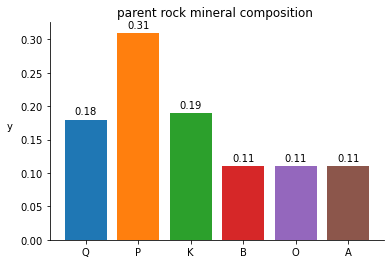

After 66 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


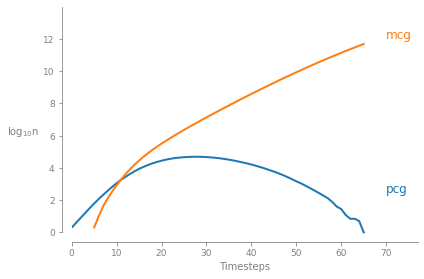

[193191.82198183 745348.49981136 780024.44817801 245432.15171529
  39666.73992379 121565.60386557]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


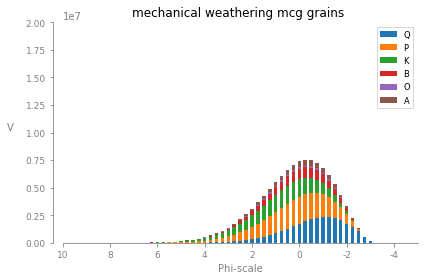

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

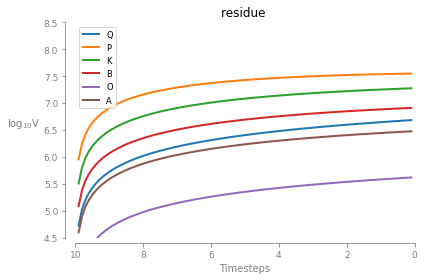

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


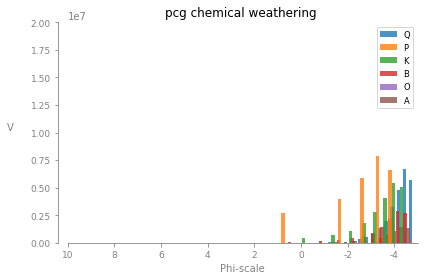

After 59 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


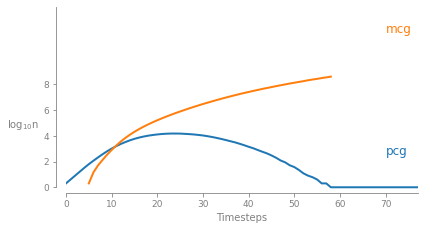

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

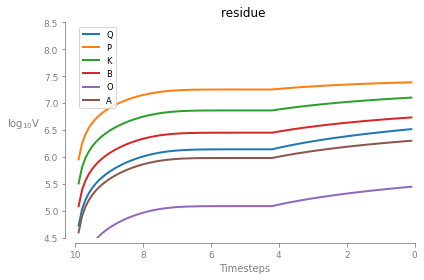

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


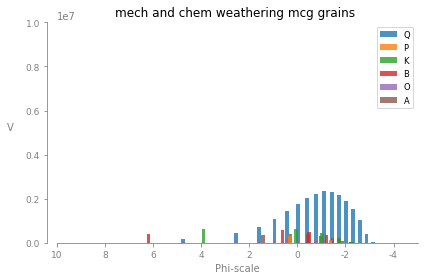

[0.4017 0.429  0.3172 0.2899 0.156  0.1586]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 3
too few P -1
too much K 1
too few B -1
too few O -1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


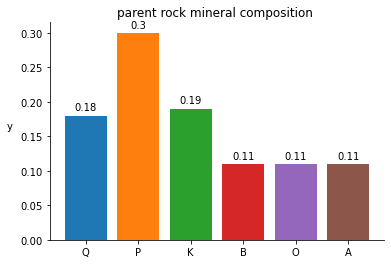

After 68 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


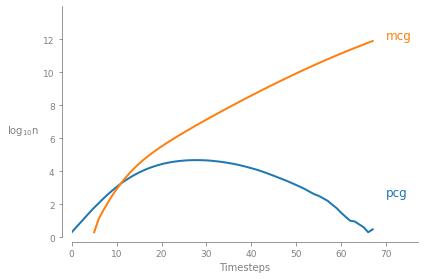

[247577.4573214  892196.12297232 903906.28283652 318118.85822842
  52687.12753643 159979.23664172]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


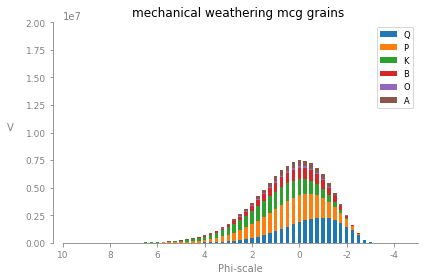

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

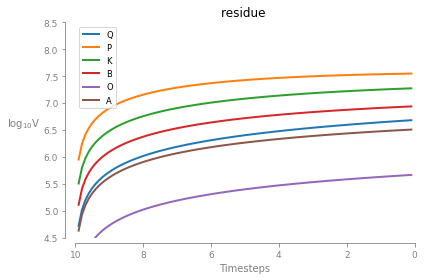

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


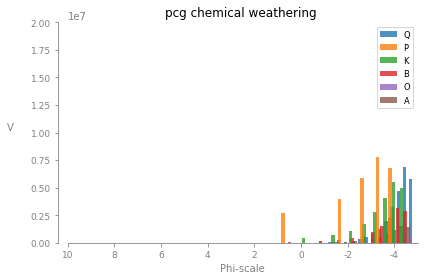

After 54 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


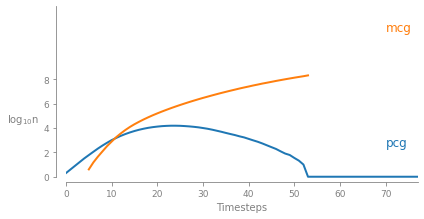

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

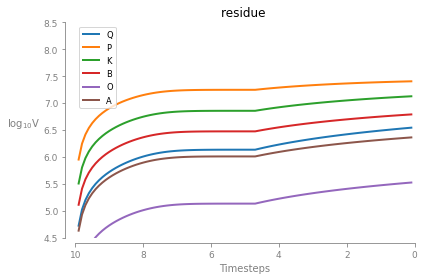

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


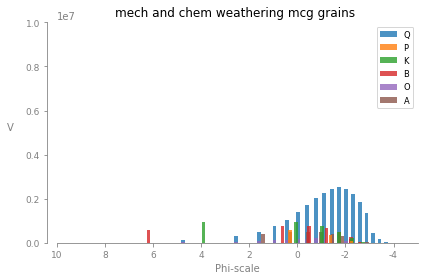

[0.4326 0.462  0.3416 0.3122 0.168  0.1708]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too few Q -1
too much P 1
all good K 0
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


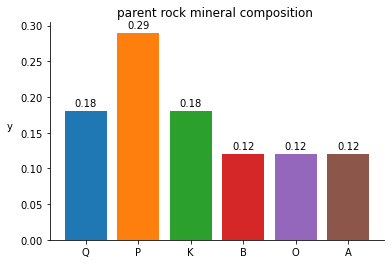

After 62 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


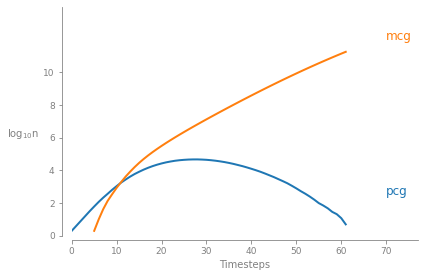

[114509.25316519 478204.66383987 548102.81150372 175045.76637847
  29180.07345641  88171.49702312]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


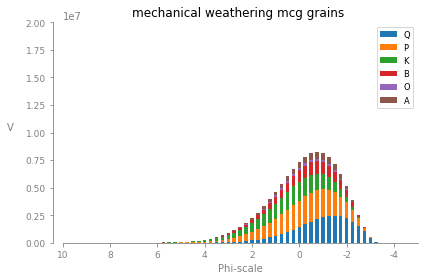

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

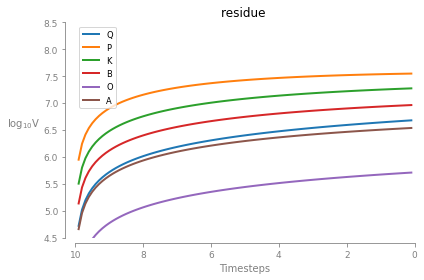

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


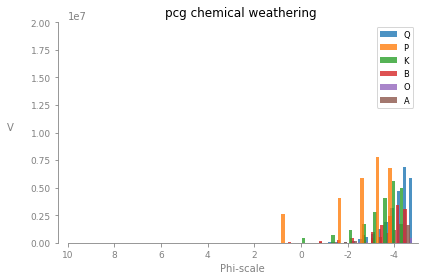

After 60 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


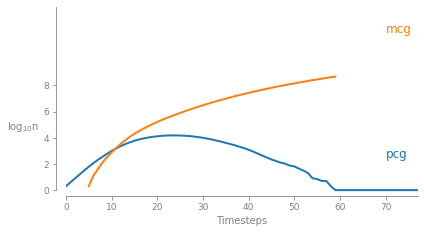

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

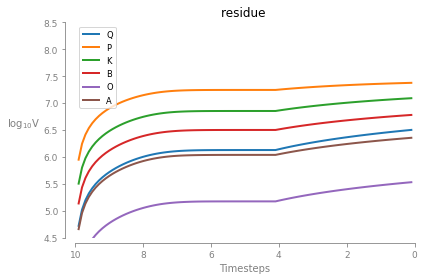

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


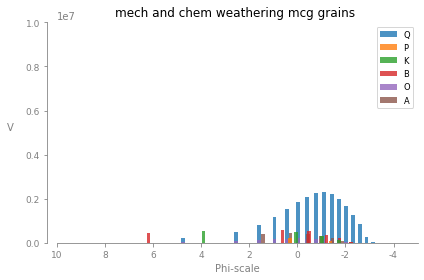

[0.4635 0.495  0.366  0.3345 0.18   0.183 ]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 14
too few P -5
too few K -4
too few B -2
all good O 0
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


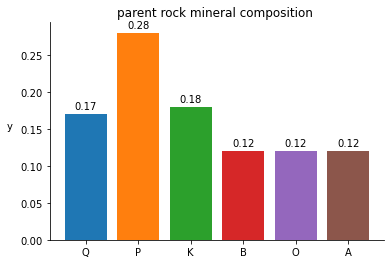

After 65 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


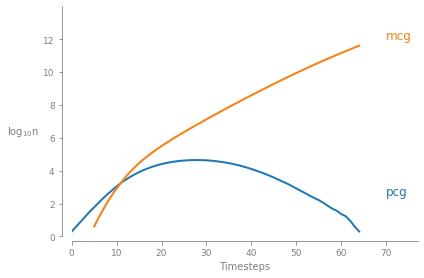

[169297.42518298 682912.23321996 727399.86306849 263994.01435935
  45656.21885169 139126.74128113]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


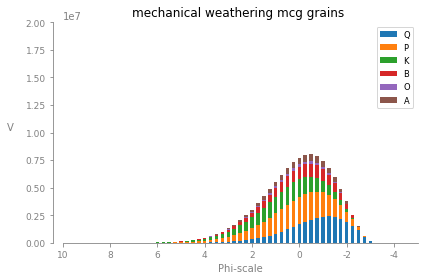

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

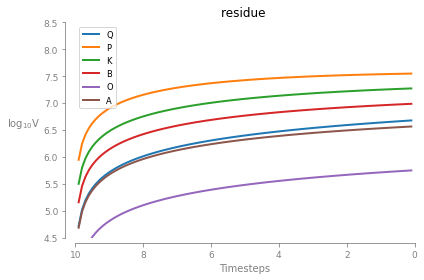

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


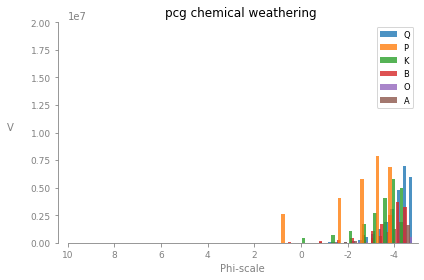

After 52 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


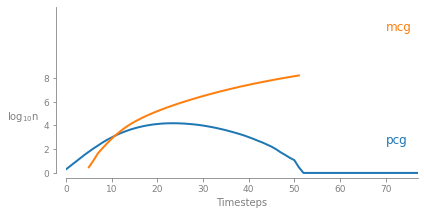

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

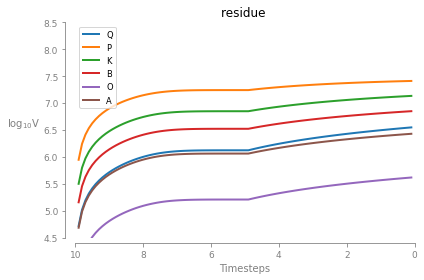

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


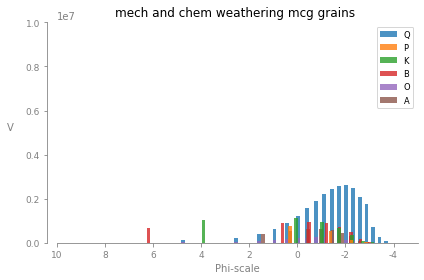

In [18]:
modal = modal_mineralogy[2]
csds_mean = csds_means[2]
percentage = -0.5
print(csds_means[2])
while percentage != 0.6:

    meangrainsize = csds_mean + (csds_mean * percentage)
    print(meangrainsize)
    
    sedgen = SedGen(minerals, 1e8, modal, meangrainsize, csds_stds[2],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03])
    
    pluton = ""
    name_addition = "grain_size_variation" + str(percentage)
    modalminplot(pluton, sedgen, "sedgen" + name_addition)
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech" + name_addition)
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + name_addition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem" + name_addition)
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + name_addition)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    
    
    percentage += 0.1

variation of modal_mineralogy with grain size cst: 
we use the modal mineralogies of the different plutons, however grain size/crystal is cst at the mean of all 6 plutons this to show the influence of the modal mineralogy unaffected by differences in grain size.

In [22]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/modal_variation_grainsize_cst'#modflow model
os.chdir(wdir)

[0.247      0.28633333 0.21183333 0.24583333 0.0905     0.10666667]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 5
too few P -2
all good K 0
all good B 0
too few O -1
too few A -2
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


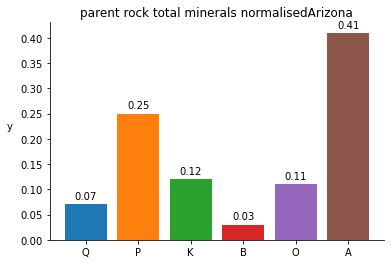

After 74 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


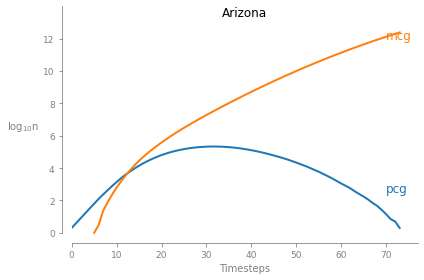

[ 235672.53228902 1444931.0628257   576450.43940832  190185.95241669
   40196.66853823  501808.8515072 ]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


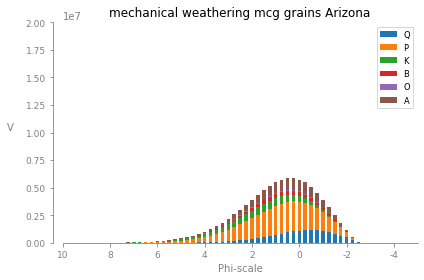

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

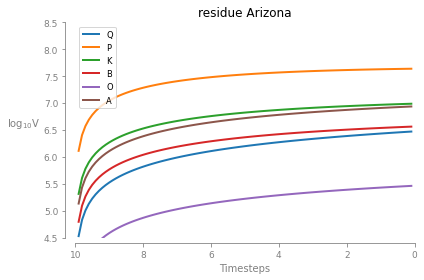

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


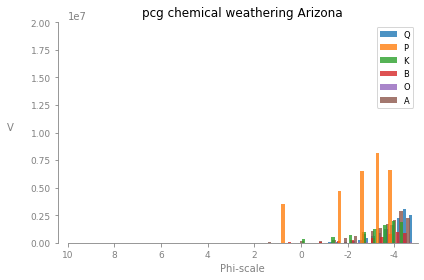

After 61 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


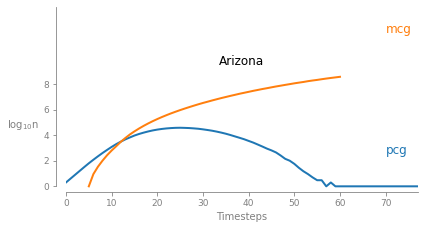

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

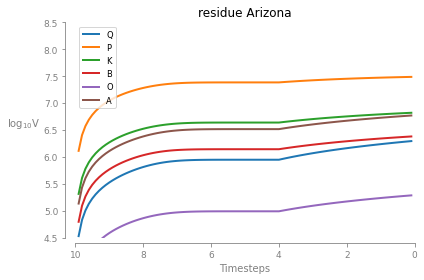

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


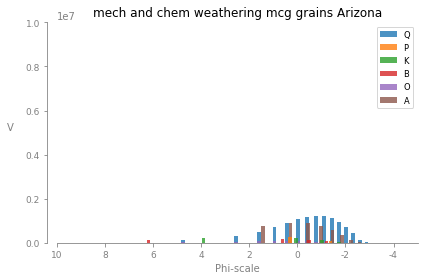

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
all good Q 0
too few P -1
all good K 0
all good B 0
too much O 1
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


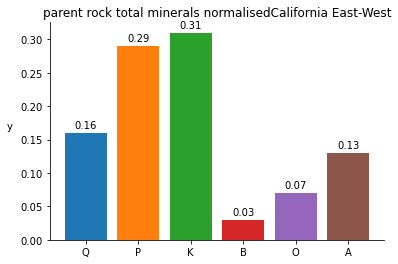

After 74 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


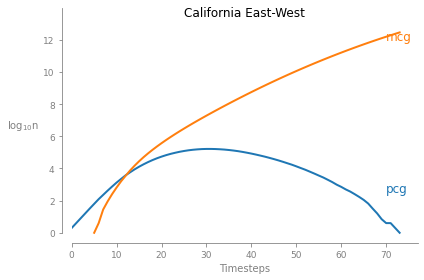

[ 385651.99026032 1301386.41444856 1080699.48775289  149456.56605357
   20389.80724924  157728.99137726]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


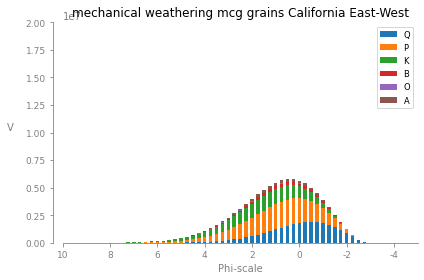

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

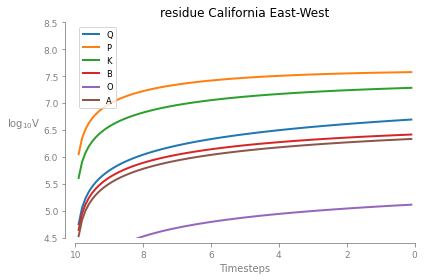

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


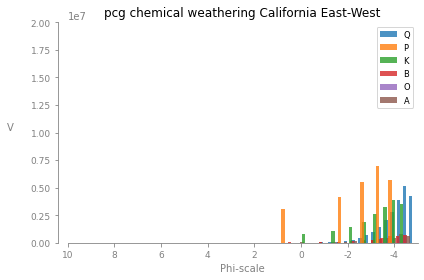

After 64 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


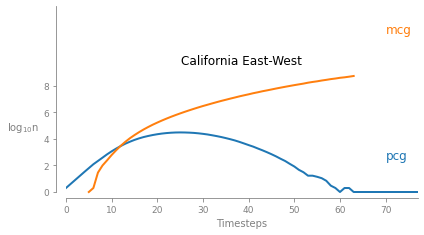

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

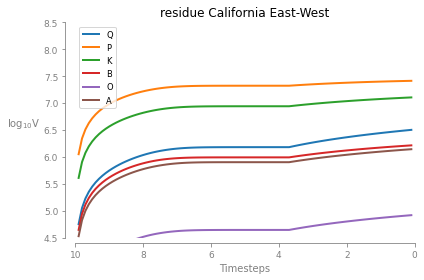

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


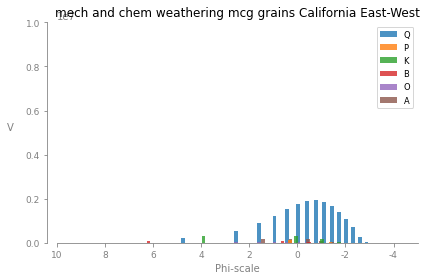

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too few Q -2
too much P 1
all good K 0
too much B 1
too few O -1
too much A 1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


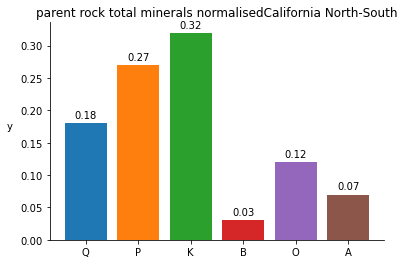

After 74 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


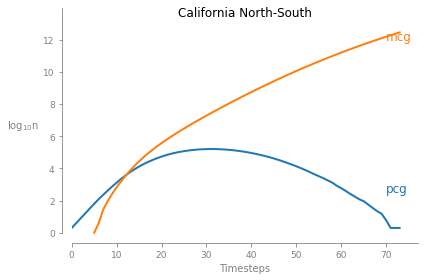

[ 417419.30286785 1215063.31664449 1132645.64705863  148868.5151532
   32110.59779504   85247.51881952]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


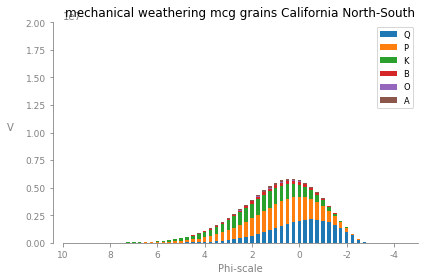

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

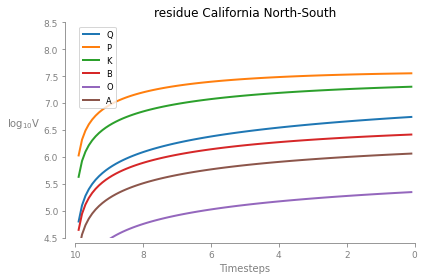

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


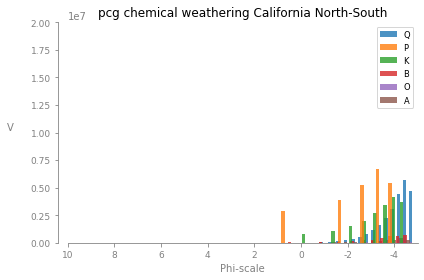

After 60 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


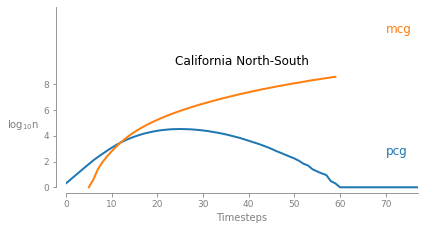

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

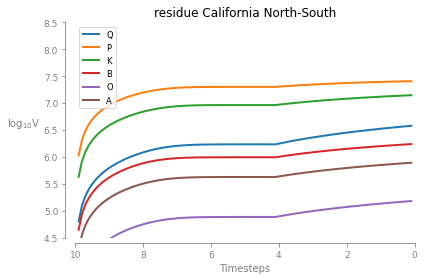

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


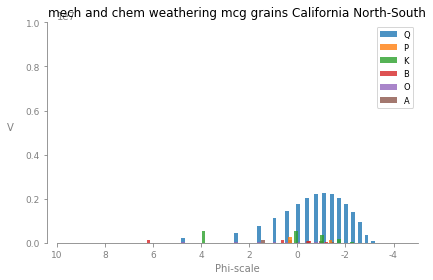

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 32
too few P -9
too few K -8
too few B -1
too few O -1
too few A -13
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


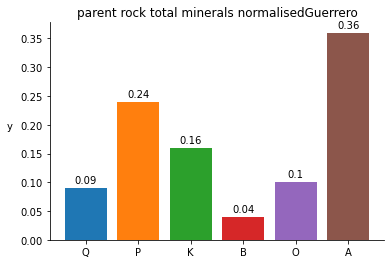

After 84 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


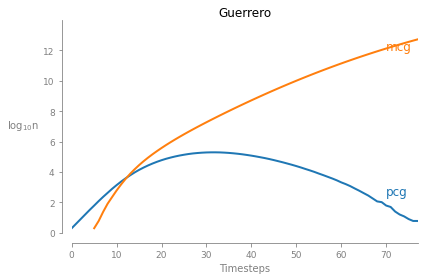

[ 600343.50433037 2030000.03916043  842679.93795334  335509.65817719
   51476.8464798   709829.9269086 ]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


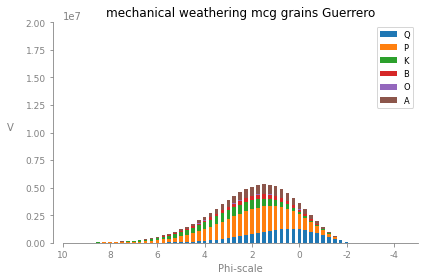

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

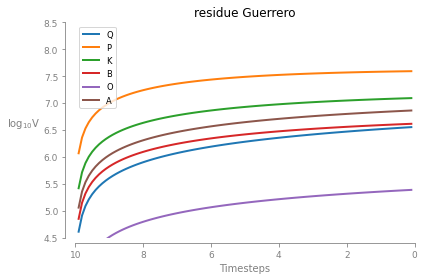

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


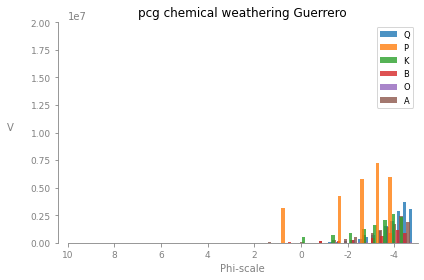

After 66 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


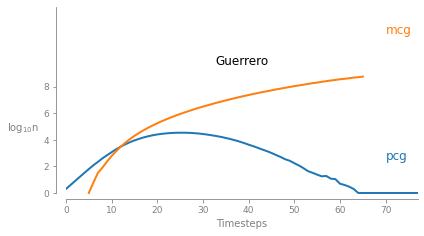

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

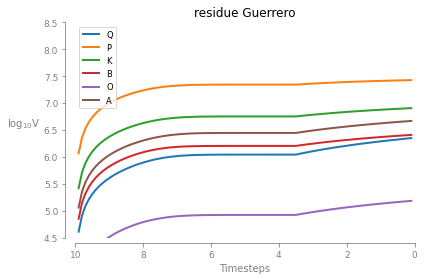

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


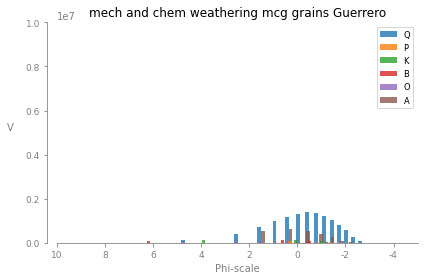

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too few Q -5
too much P 1
too much K 1
too much B 1
too much O 1
too much A 1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


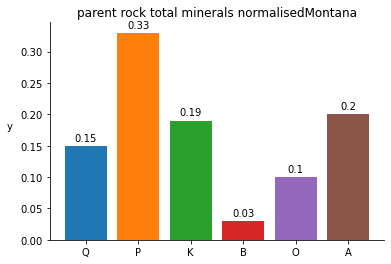

After 76 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


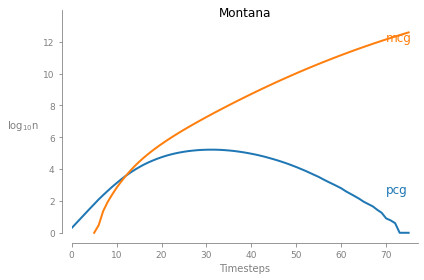

[ 445214.35242085 1693293.65643944  770231.613731    174817.98980331
   31253.80456669  244539.05783617]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


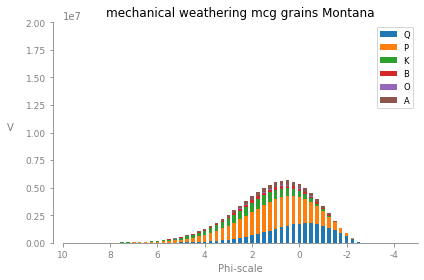

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

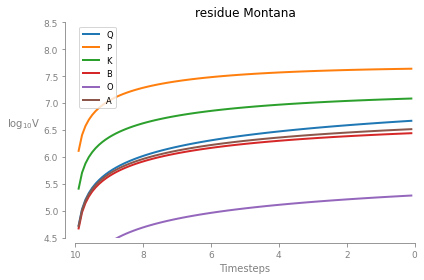

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


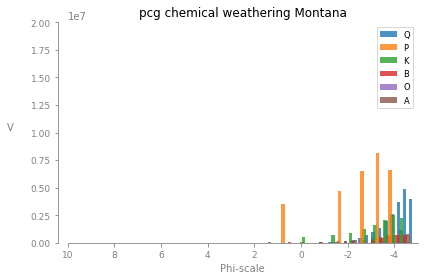

After 61 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


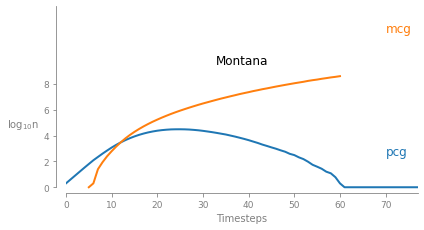

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

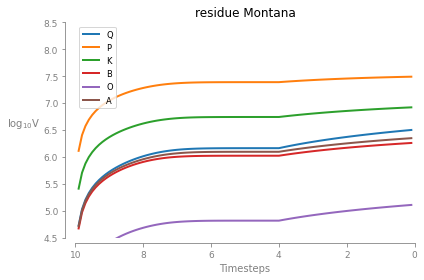

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


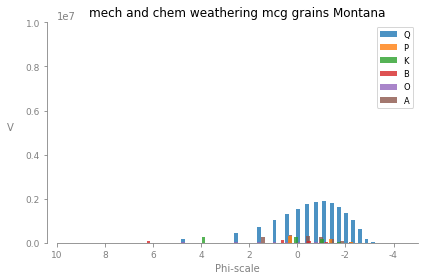

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 14
too few P -6
all good K 0
too few B -2
all good O 0
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


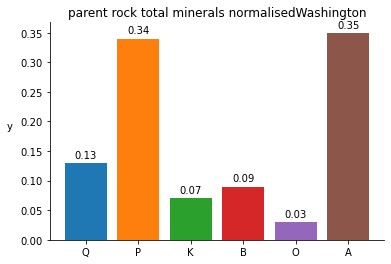

After 76 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


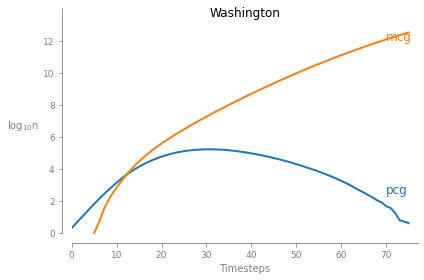

[ 385744.15637299 1745035.20393023  290350.88744997  414601.70849805
   12854.25052317  412100.0983548 ]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


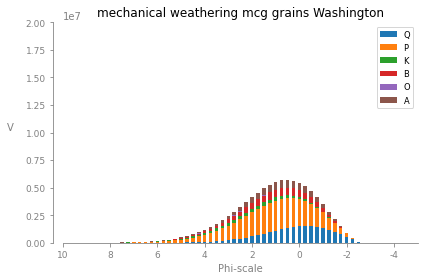

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

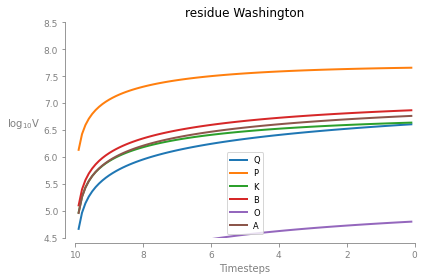

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


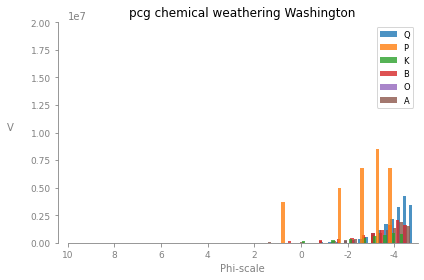

After 60 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


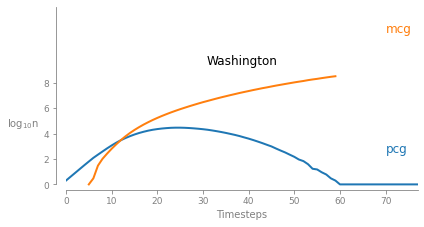

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

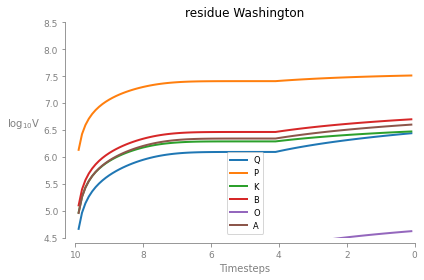

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


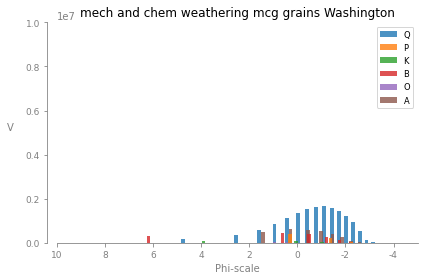

In [23]:
grainsize = csds_means.mean(axis = 0)
std = csds_stds.mean(axis = 0)

print(grainsize)
for i in range(6):
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], grainsize, std,
                    learning_rate = 1000,
                    auto_normalize_modal_mineralogy = True,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03])
    pluton = plutonname(i)
    name_addition = "modal_variation" 
    modalminplot(pluton, sedgen, "sedgen" + name_addition)
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech" + name_addition)
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + name_addition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem" + name_addition)
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + name_addition)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    
    

variation of intra_cb_p:

In [23]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/intracbvariation'#modflow model
os.chdir(wdir)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


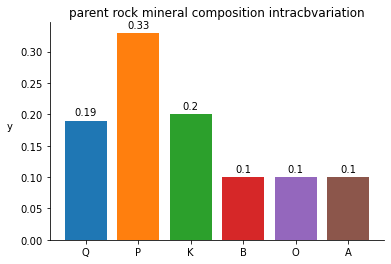

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)
<ipython-input-10-aa12220b089c>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


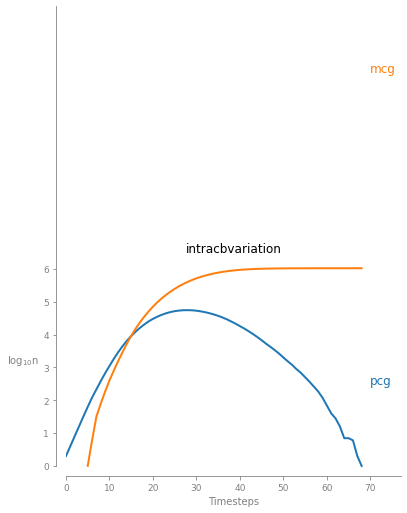

[23.24107716 44.8972274  25.21669324 12.30014794 14.76166907 12.98901166]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


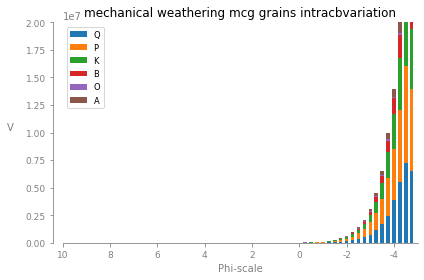

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

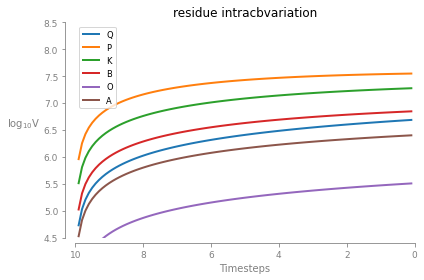

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


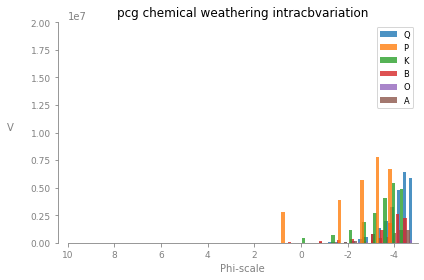

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)
<ipython-input-10-aa12220b089c>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


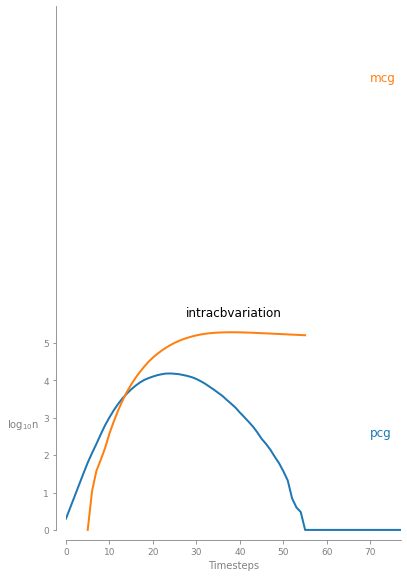

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

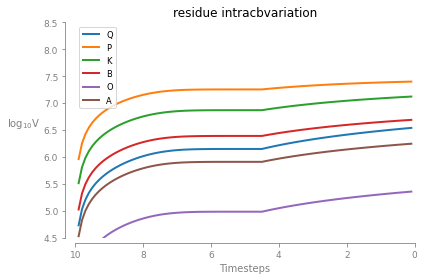

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


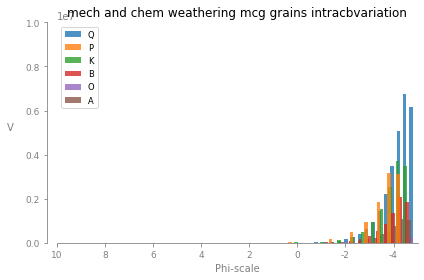

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


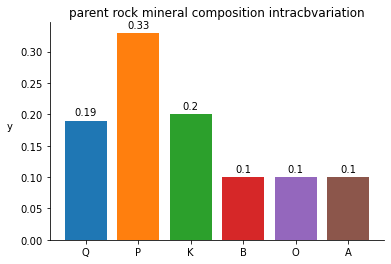

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


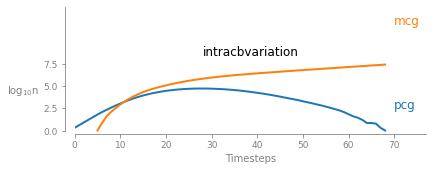

[ 324.437325   1102.65071852  881.36574752  292.67879651  177.73517205
  224.78989576]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


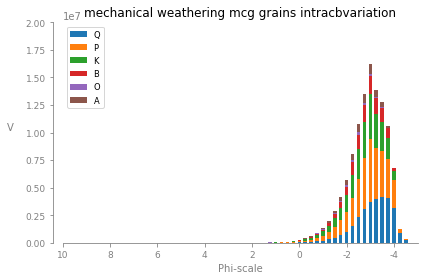

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

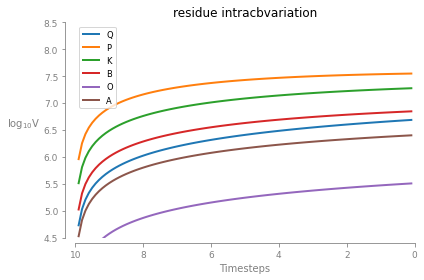

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


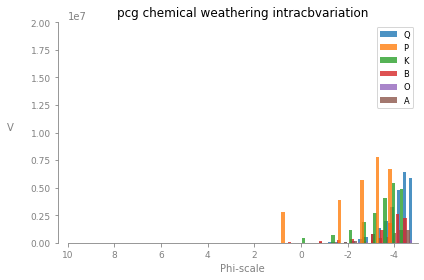

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)
<ipython-input-10-aa12220b089c>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


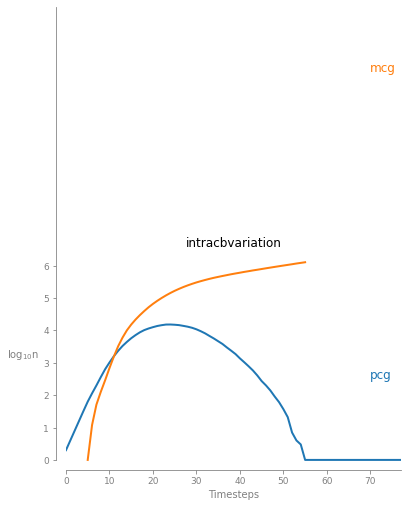

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

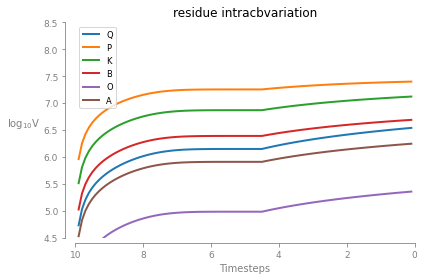

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


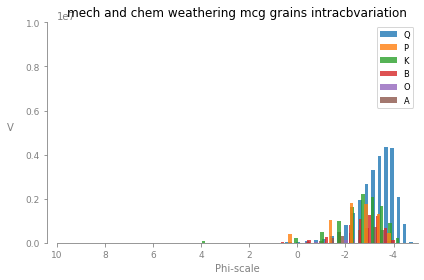

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


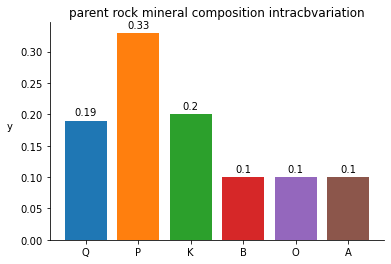

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


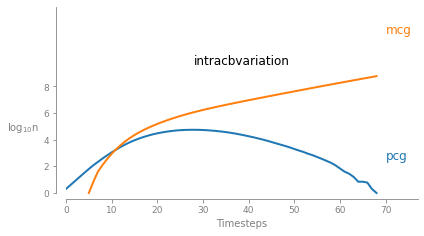

[ 3004.23495871 14136.25795914 14872.77779221  3884.2392456
  1215.41808431  2339.31350136]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


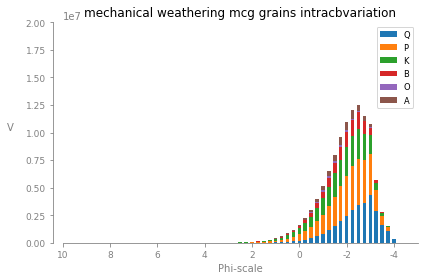

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

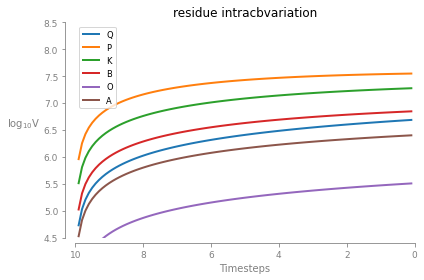

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


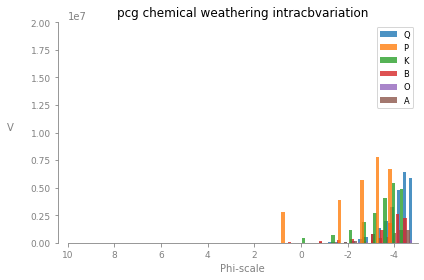

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


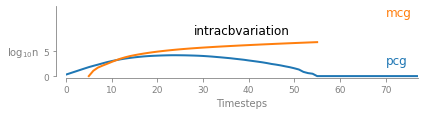

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

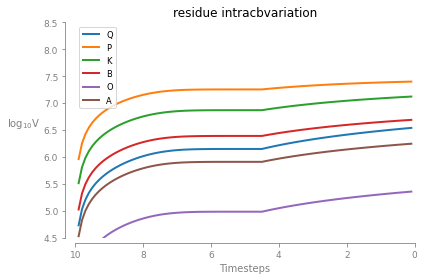

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


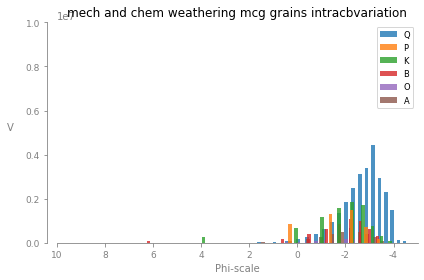

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


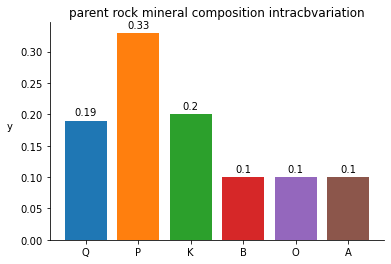

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


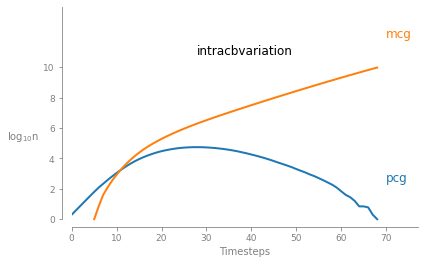

[ 20016.95074271 100287.08768787 118284.11001687  29067.57468433
   5735.0753747   15027.83307532]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


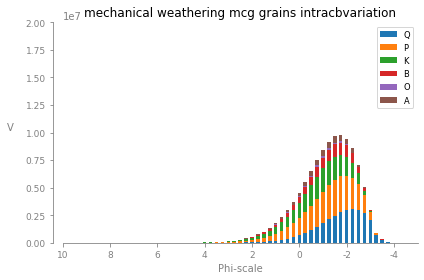

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

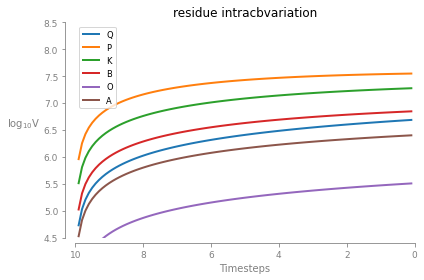

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


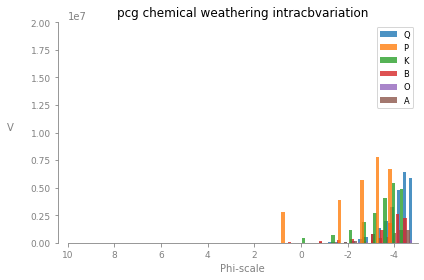

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


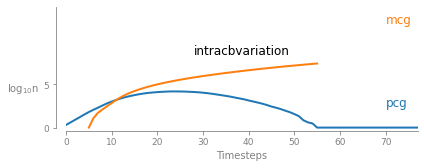

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

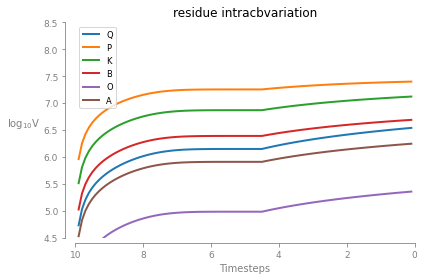

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


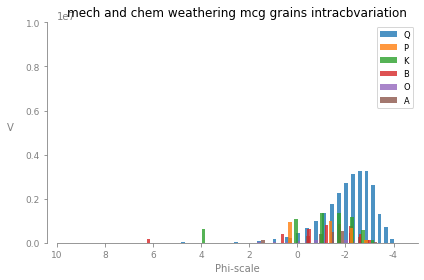

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


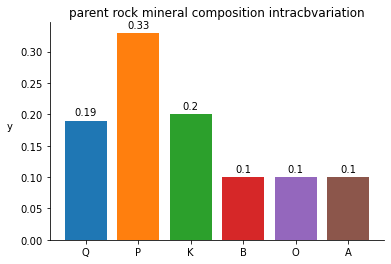

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


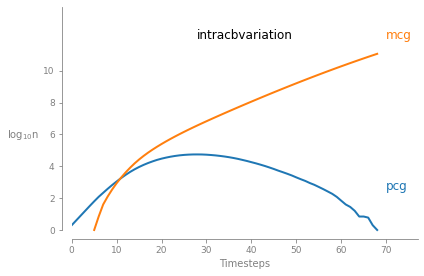

[ 88044.74326622 399234.5444512  447444.98377317 119059.46629854
  18219.70034414  57652.57541759]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


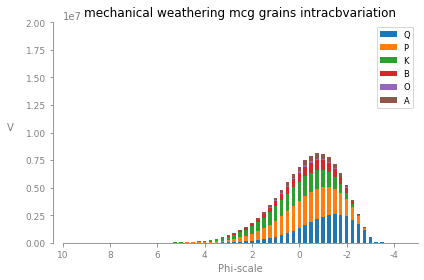

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

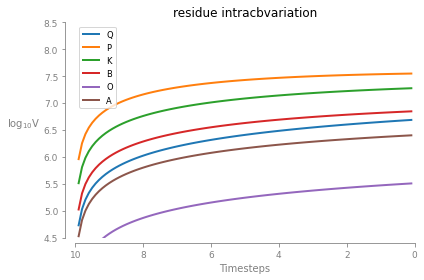

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


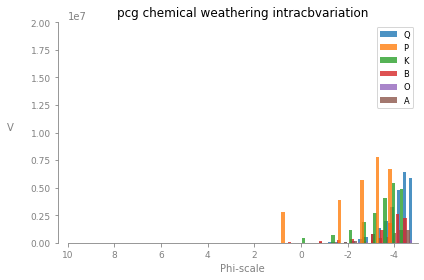

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


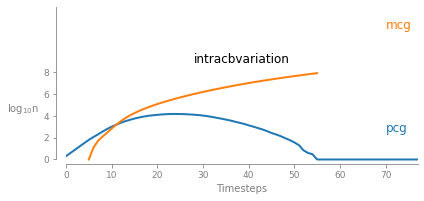

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

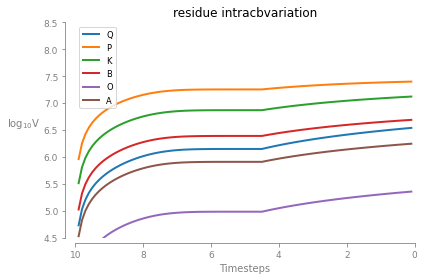

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


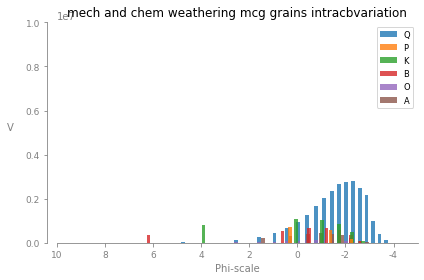

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


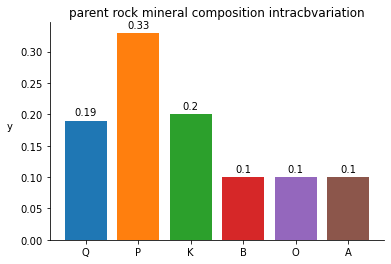

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


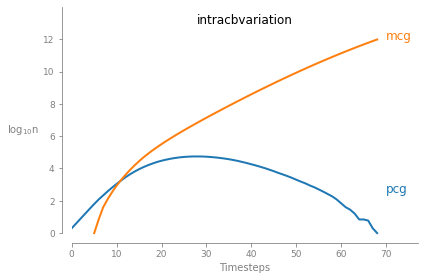

[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


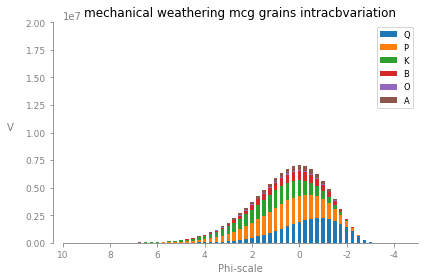

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

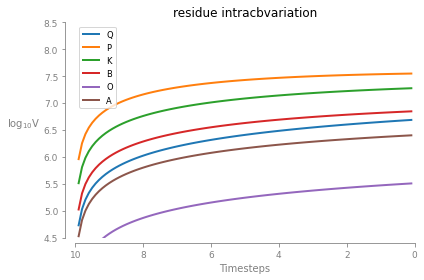

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


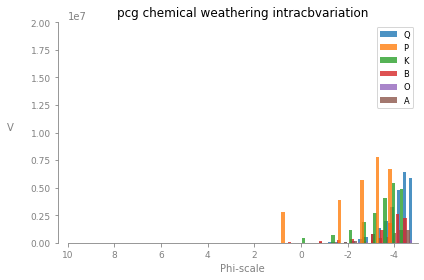

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


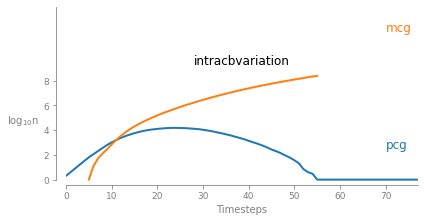

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

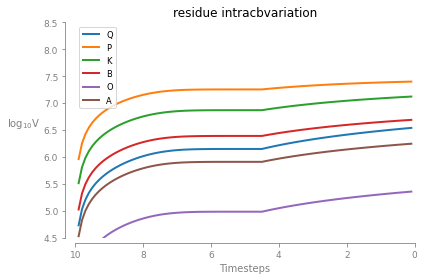

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


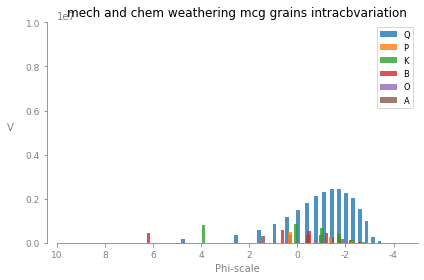

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


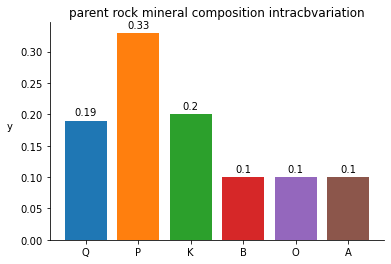

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


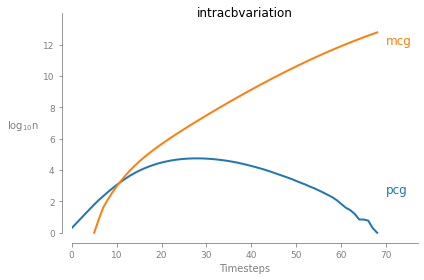

[ 589337.94844836 1588601.54879733 1317270.53756384  495170.05833095
   66388.30272283  241202.43930315]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


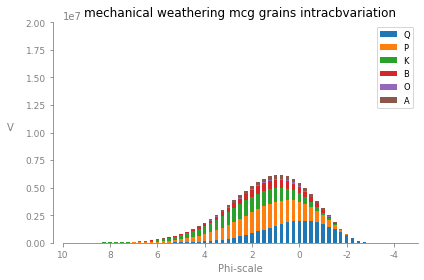

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

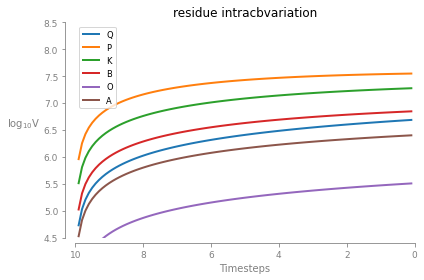

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


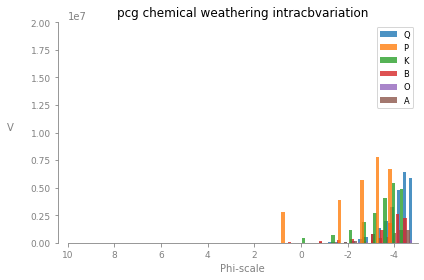

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


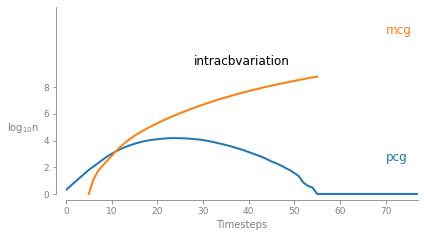

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

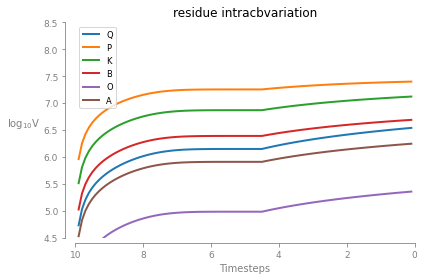

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


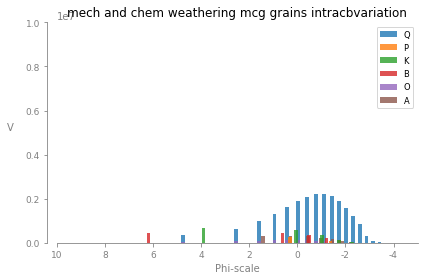

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


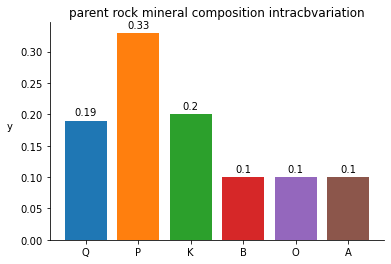

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


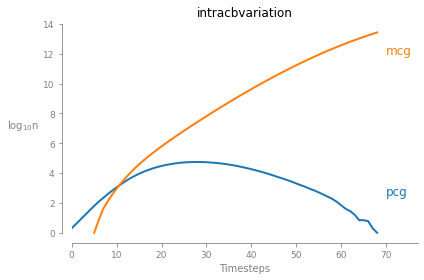

[ 979487.52756559 1894323.3009905  1276779.75066342  603441.57041354
   86316.41348531  309641.26634642]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


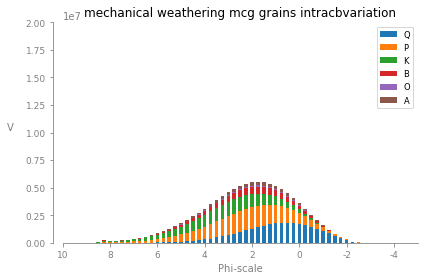

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

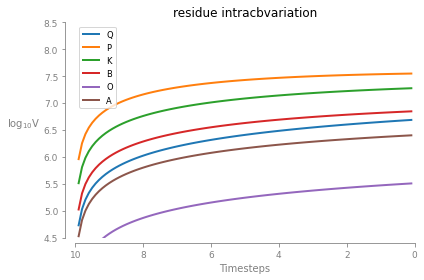

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


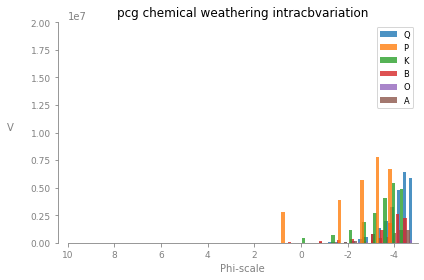

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


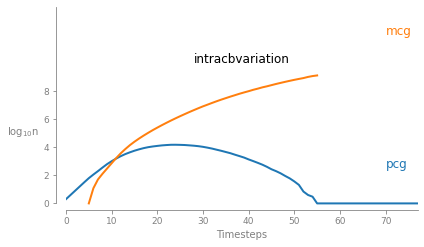

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

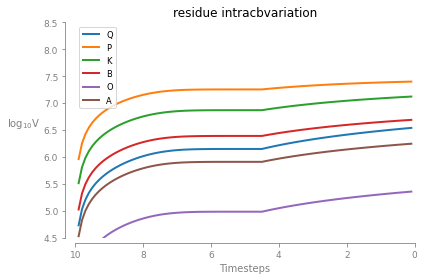

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


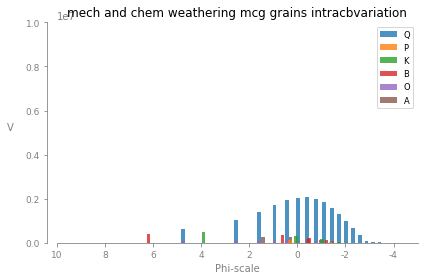

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


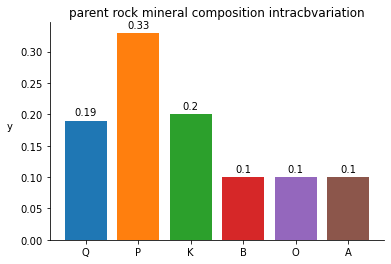

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


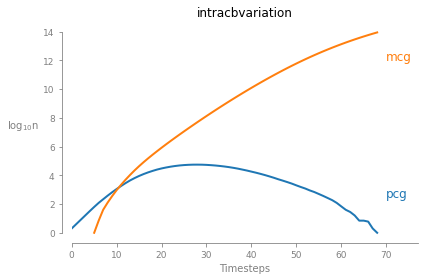

[1337378.1271462  1768943.83717444  958045.23278883  582214.59212296
   88308.51276438  302479.28675598]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


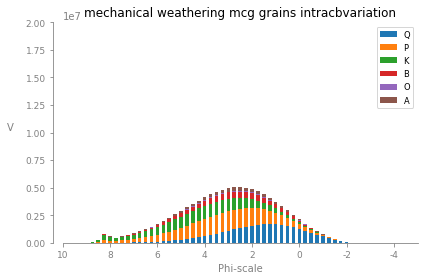

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

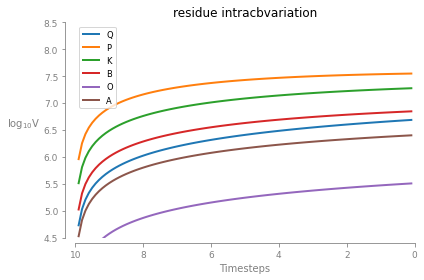

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


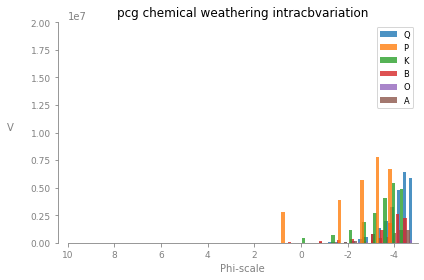

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


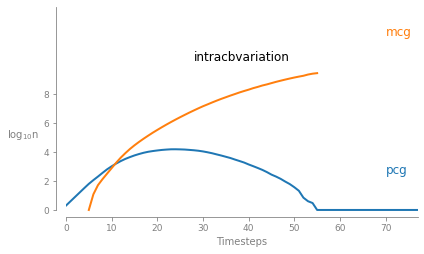

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

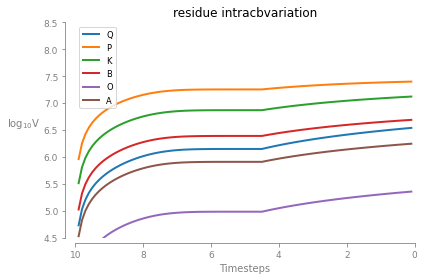

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


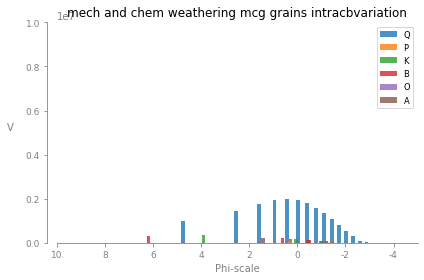

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


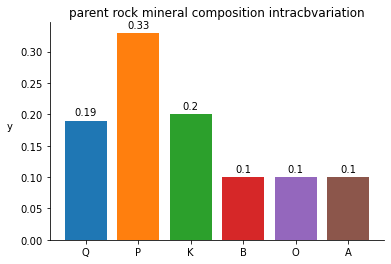

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


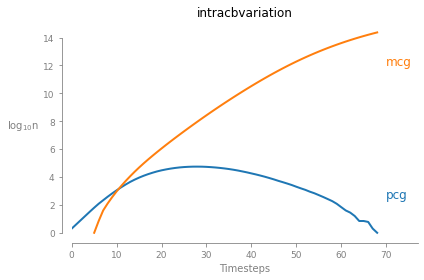

[1497034.26925873 1362612.82090618  587689.94559584  465102.83663939
   76472.40258452  247974.76730884]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


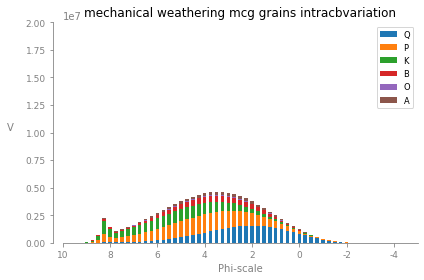

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

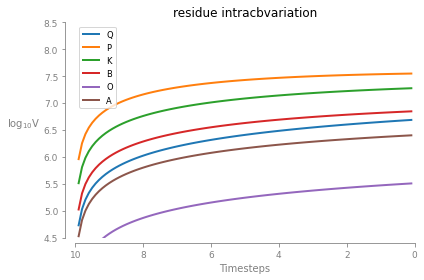

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


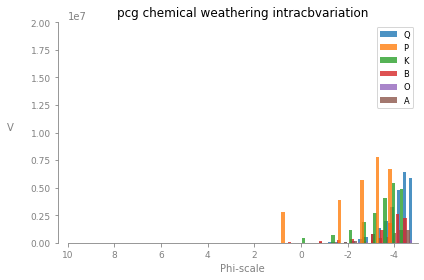

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


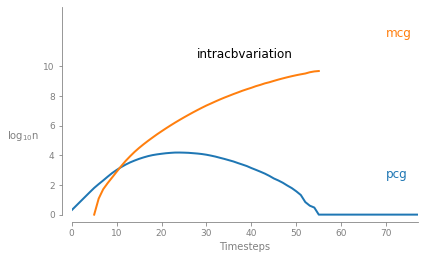

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

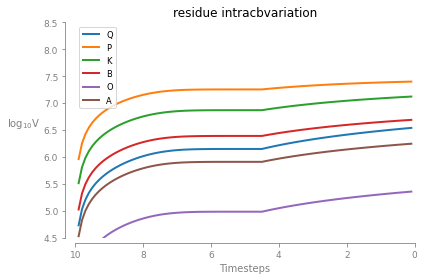

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


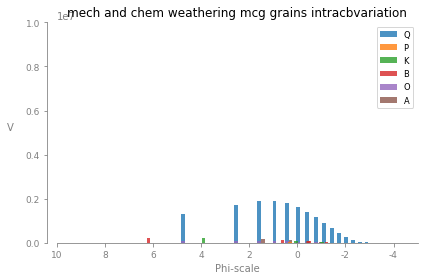

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


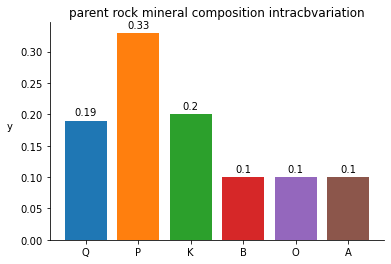

After 69 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


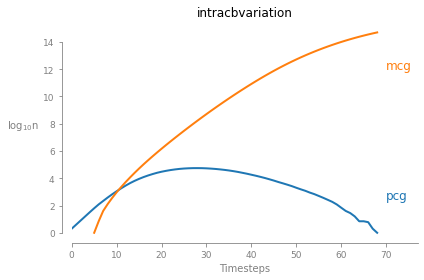

[1445401.55858978  909703.59879626  317183.60609473  325324.89654273
   57989.39792032  178339.17275134]


<ipython-input-13-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


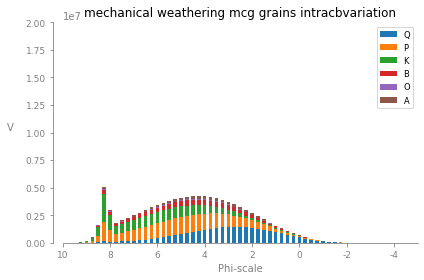

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

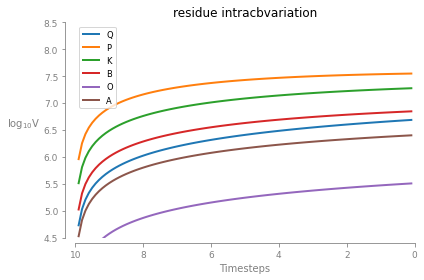

<ipython-input-12-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-12-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


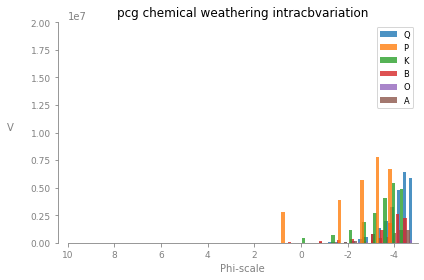

After 56 steps all pcgs have been broken down to mcg


<ipython-input-10-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


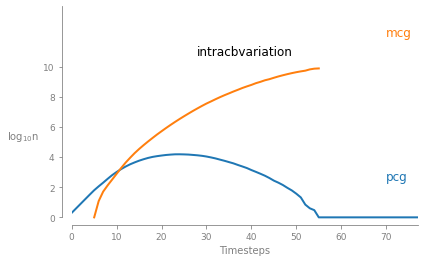

<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-11-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

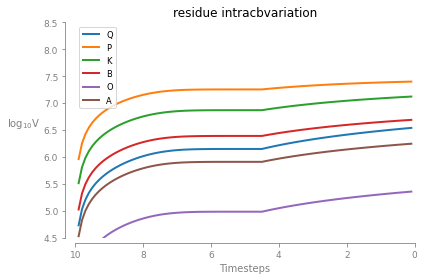

<ipython-input-14-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


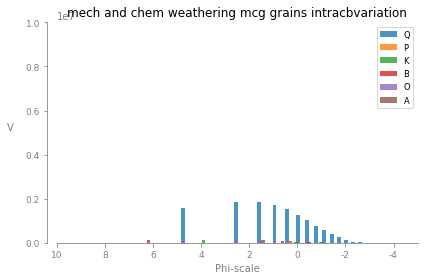

In [24]:
intracblist = np.arange(0,1.1,0.1)
for i in intracblist: 
    
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[2], csds_means[2], csds_stds[2],
                    learning_rate = 1000,
                    auto_normalize_modal_mineralogy = True,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    intra_cb_p = [i])

        #establishing plutonname
    pluton = "intracbvariation"
    nameaddition = str(i)
    modalminplot(pluton, sedgen, "sedgen")
    
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech" + nameaddition)
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + nameaddition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem" + nameaddition)
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + nameaddition)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech"+ nameaddition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + nameaddition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + nameaddition)

How does weathering evolution change when enable_pcg_selection is set on for all plutons?
=> let every pluton run with enable pcg selection True and compare with "normal"

In [29]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/pcg_selection_True'#modflow model
os.chdir(wdir)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


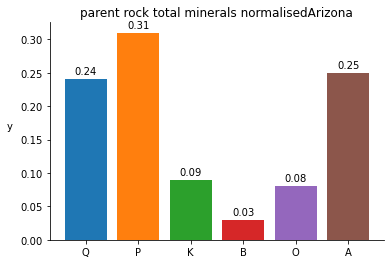

After 86 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


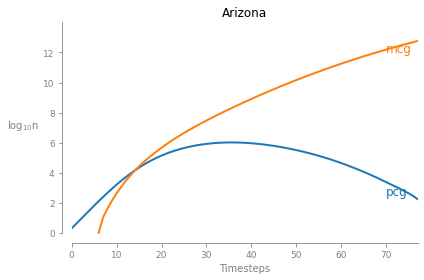

[ 575681.29559083 2169415.38830082  643194.06450702  287439.9346238
   55008.2550034   788556.02755527]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


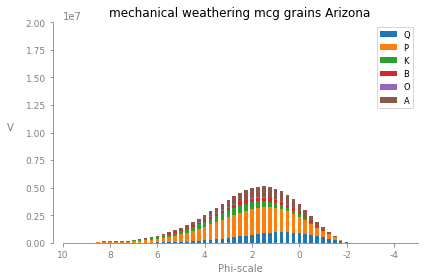

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

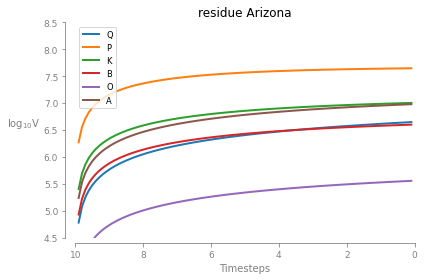

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


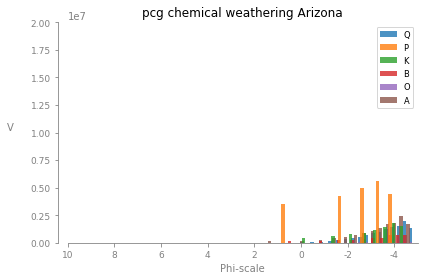

After 67 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


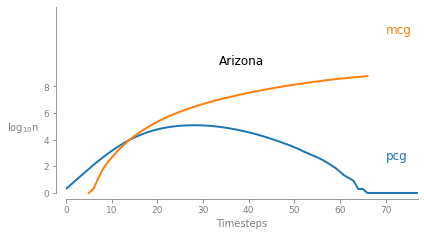

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

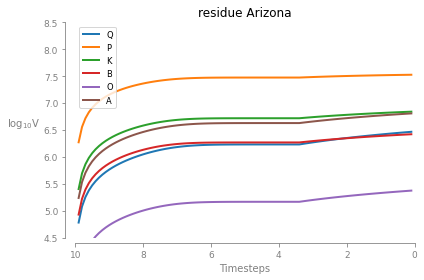

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


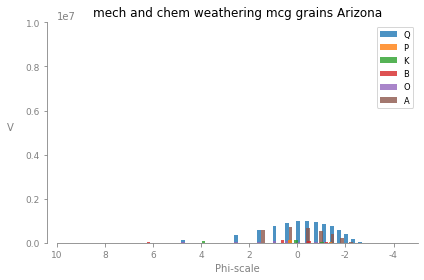

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
too few P -2
too few K -2
too few B -1
too few O -3
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


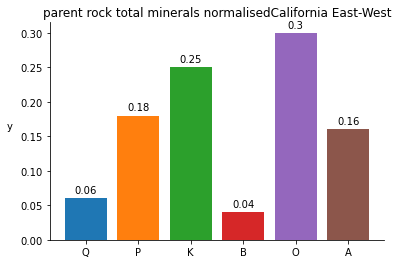

After 72 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


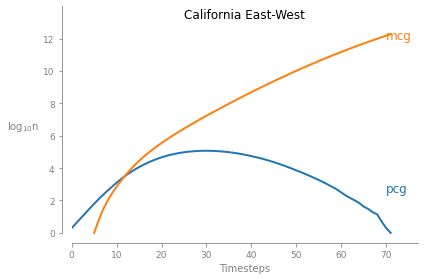

[ 275120.05911638 1126872.16789151 1031409.7516941   359504.38504331
   19987.1496215   138426.57870186]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


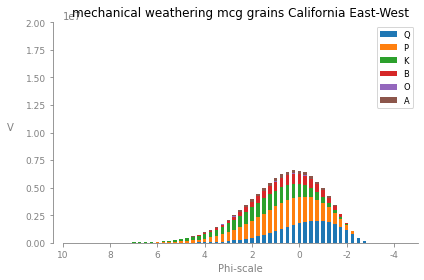

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

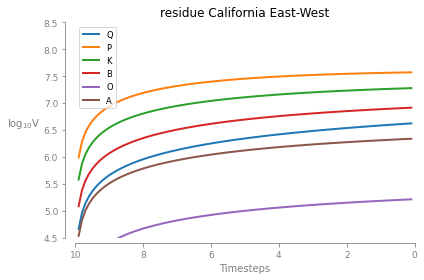

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


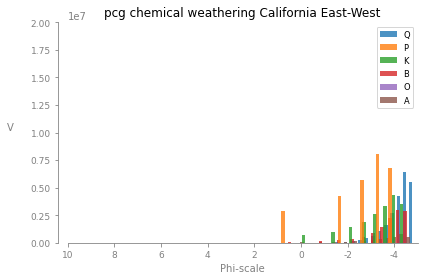

After 54 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


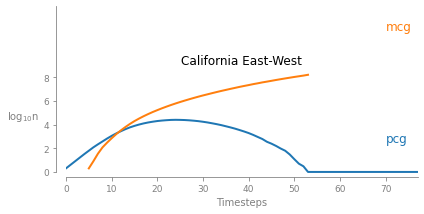

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

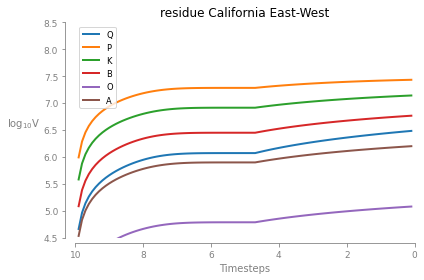

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


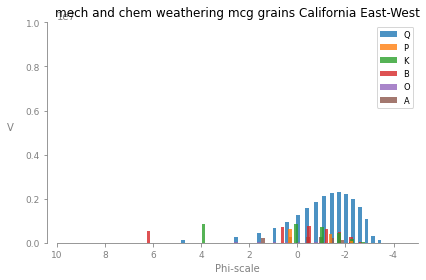

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


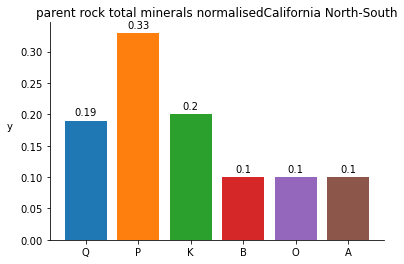

After 69 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


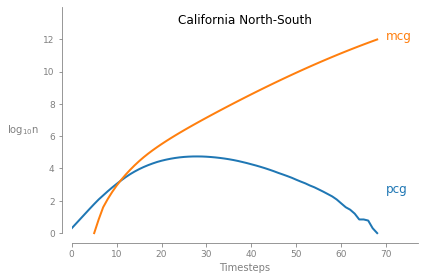

[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


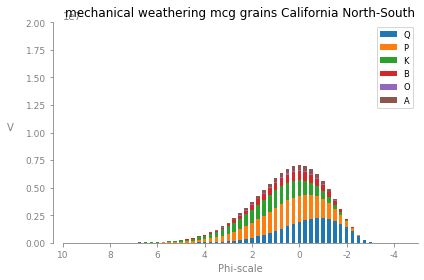

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

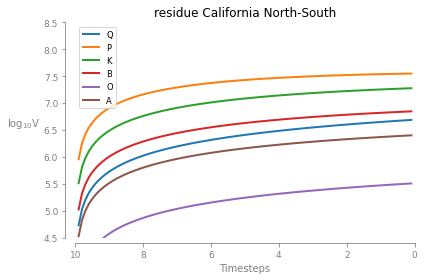

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


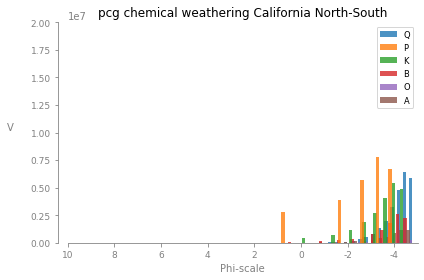

After 56 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


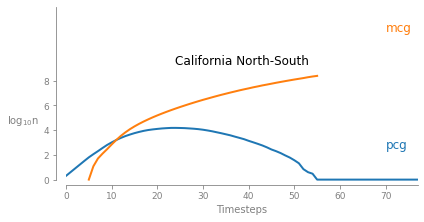

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

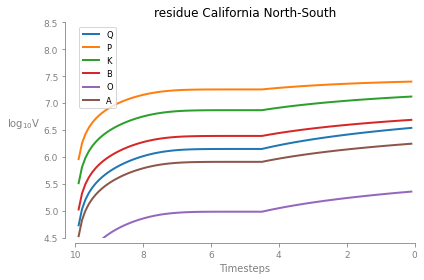

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


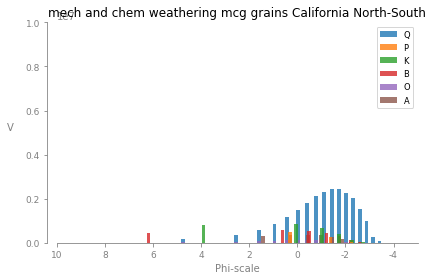

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
all good P 0
too much K 1
too few B -1
too few O -3
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


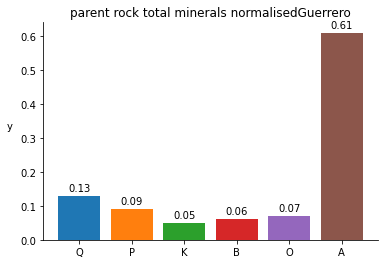

After 89 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


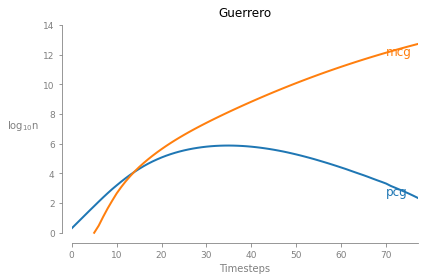

[ 796365.54563015 2079360.93276928  797997.53163764  335702.9163968
   50935.46692333  736995.13011036]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


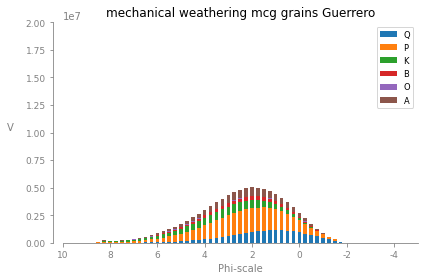

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

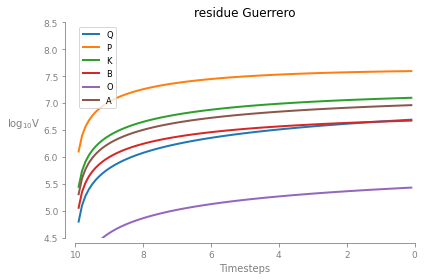

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


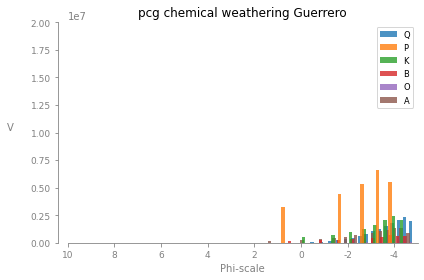

After 65 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


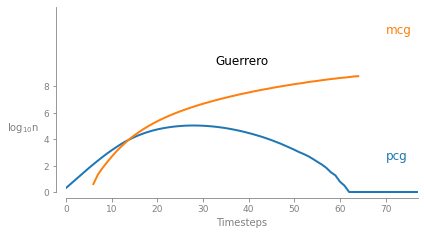

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

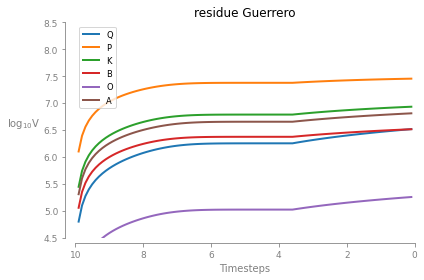

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


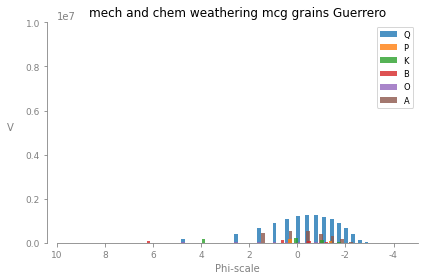

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 25
too few P -7
too few K -8
too few B -3
too few O -4
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


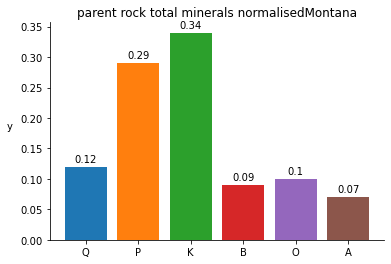

After 79 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


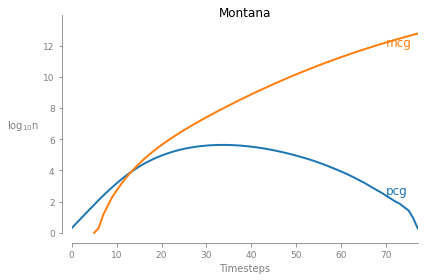

[ 497270.20130193 1755820.21318636  762540.84757123  187101.625975
   30227.5359525   236891.47237899]


<ipython-input-15-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


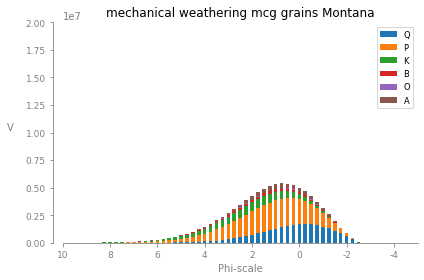

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

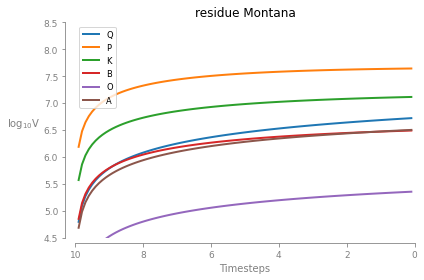

<ipython-input-14-caa5c3de06b8>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-14-caa5c3de06b8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


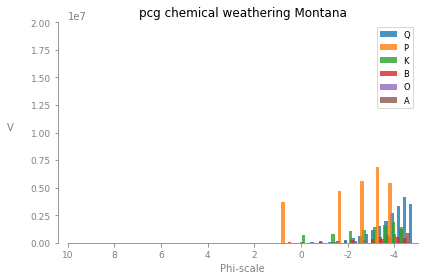

After 64 steps all pcgs have been broken down to mcg


<ipython-input-12-aa12220b089c>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


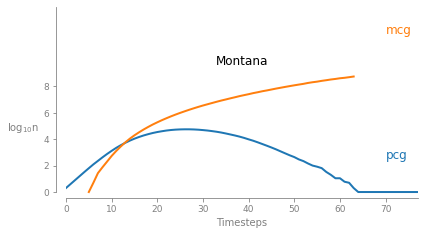

<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-13-562fff7cb6dd>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

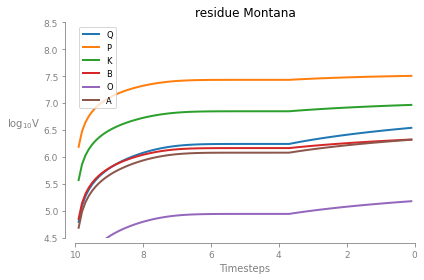

<ipython-input-16-e30e378df60a>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-16-e30e378df60a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


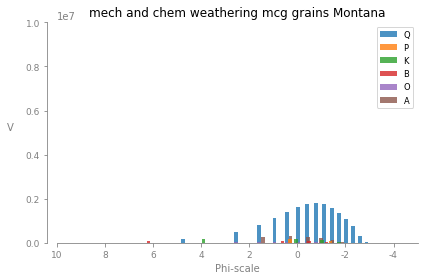

---SedGen model initialization started---

Initializing modal mineralogy...


ValueError: Provided modal mineralogy proportions do not sum to one. 
Either check them manually or enable automatic normalization by setting the 'auto_normalize_modal_mineralogy' parameter to 'True'.

In [30]:
%%time
for i in range (6): #voor alle plutons
#for i in ([2]): #testen bij slechts 1 pluton  
    #sedgen running for every pluton
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], csds_means[i], csds_stds[i],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    enable_pcg_selection = True)
        #establishing plutonname
    pluton = plutonname(i)
    name_addition = "new_input"
    modalminplot(pluton, sedgen, "sedgen" + name_addition)
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech" + name_addition)
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + name_addition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem" + name_addition)
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + name_addition)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)

tracking the different volumes of minerals through weathering at different timesteps for the model ie 0 => 100 steps
we use the other data from California north south pluton

In [51]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/n_steps'#modflow model
os.chdir(wdir)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
10/10
---SedGen model initialization finished succesfully---


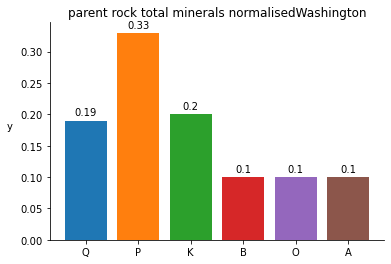

[0.00338087 0.02932665 0.02410006 0.         0.         0.        ]


<ipython-input-42-5dcc73935323>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


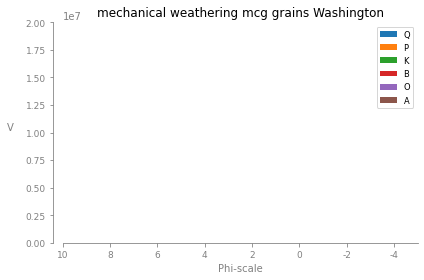

<ipython-input-41-e14308023a93>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-41-e14308023a93>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-41-e14308023a93>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


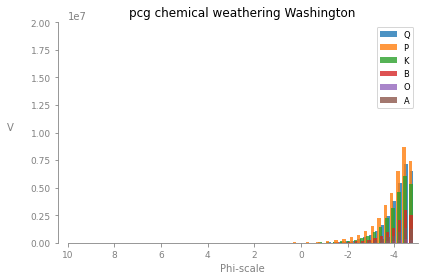

<ipython-input-49-de9cb658b093>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-49-de9cb658b093>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[nsteps, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-49-de9cb658b093>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


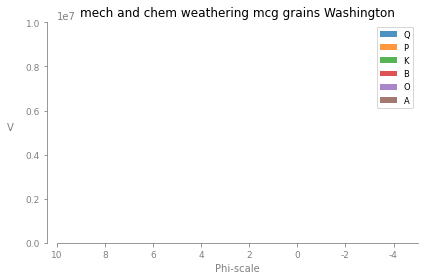

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
20/20
---SedGen model initialization finished succesfully---


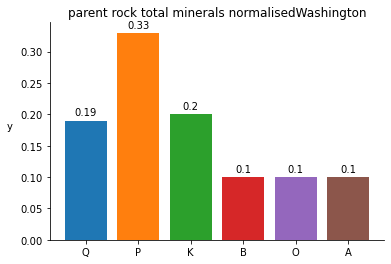

[2.25668543 8.34712002 9.24138436 2.03705384 1.69500333 1.73250039]


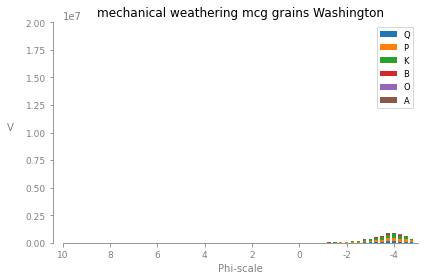

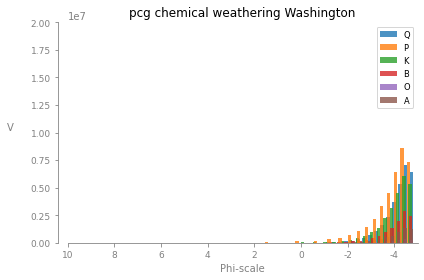

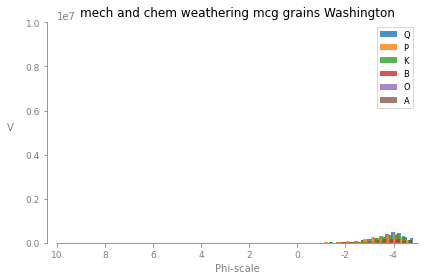

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
30/30
---SedGen model initialization finished succesfully---


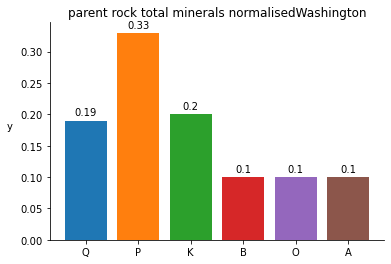

[ 75.76337816 312.79022445 355.16882437  82.96268438  43.45623945
  61.35651674]


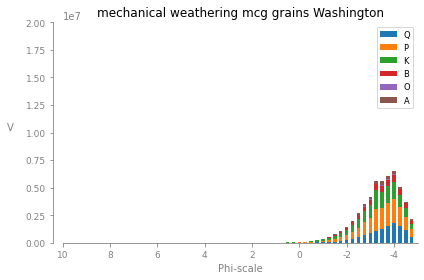

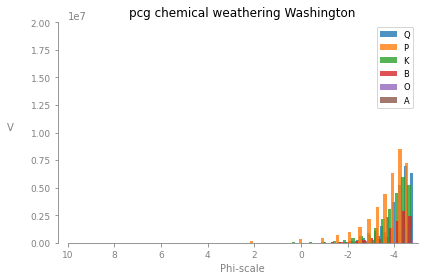

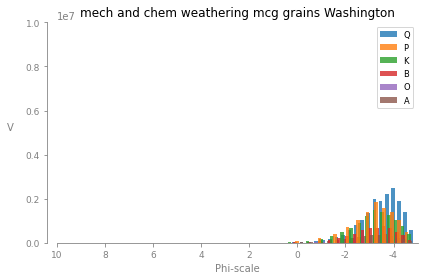

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
40/40
---SedGen model initialization finished succesfully---


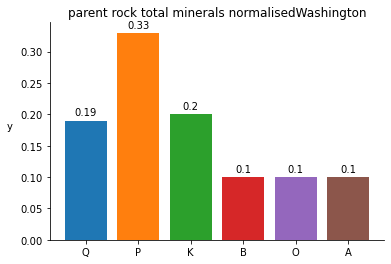

[1082.97634562 5728.52092622 7101.84919486 1484.20834755  430.2263574
  880.02644615]


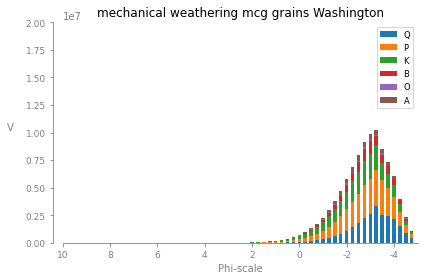

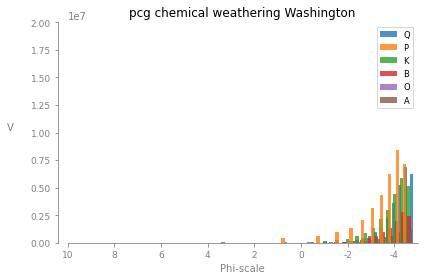

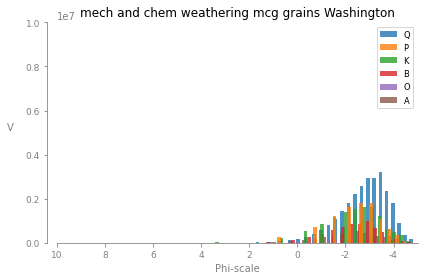

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
50/50
---SedGen model initialization finished succesfully---


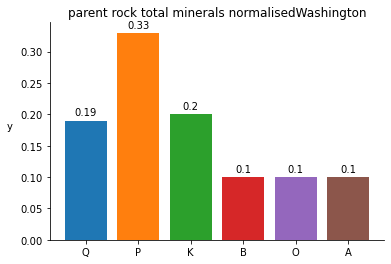

[10536.9349268  56754.502522   72587.90801708 15736.55527327
  3005.52257879  8041.0577824 ]


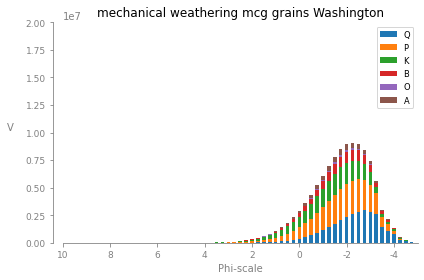

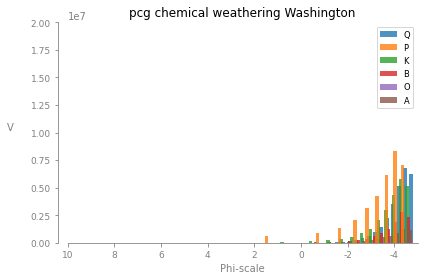

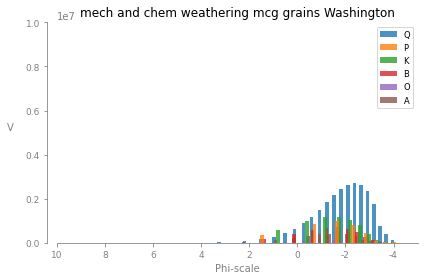

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
60/60
---SedGen model initialization finished succesfully---


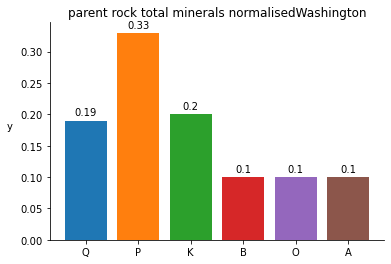

[ 66637.62733826 310878.87286999 362604.58278751  89655.19138276
  13746.71981941  45173.11362782]


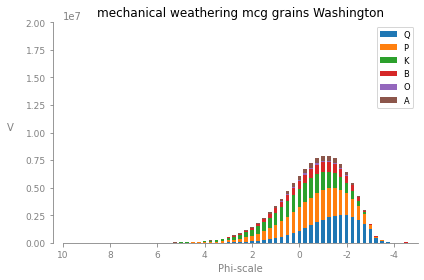

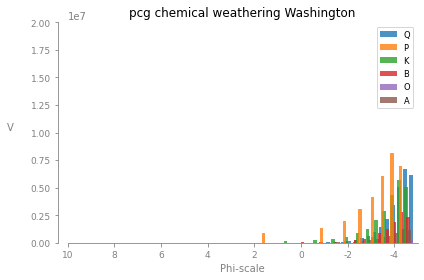

After 56 steps all pcgs have been broken down to mcg


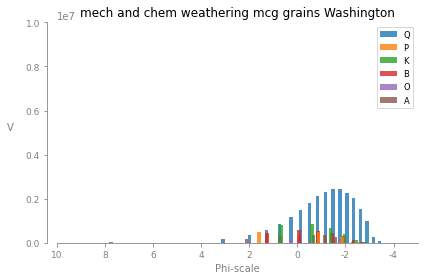

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
70/70
---SedGen model initialization finished succesfully---


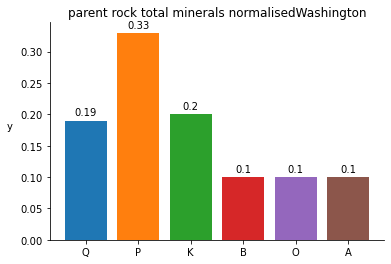

After 69 steps all pcgs have been broken down to mcg
[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


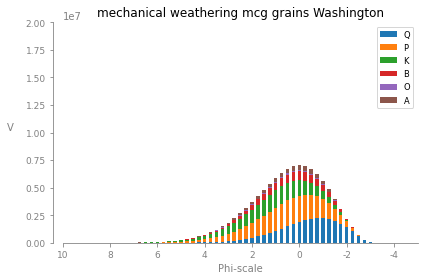

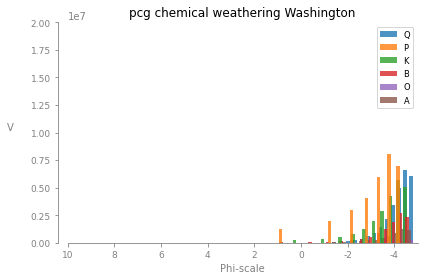

After 56 steps all pcgs have been broken down to mcg


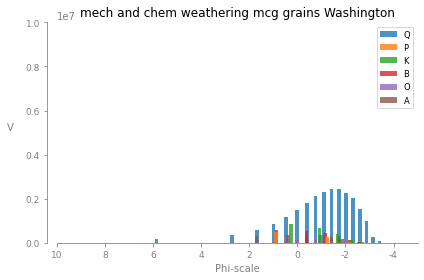

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
80/80
---SedGen model initialization finished succesfully---


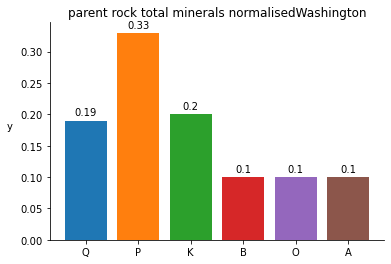

After 69 steps all pcgs have been broken down to mcg
[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


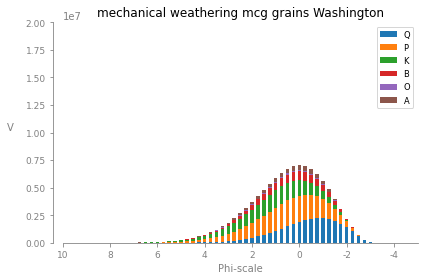

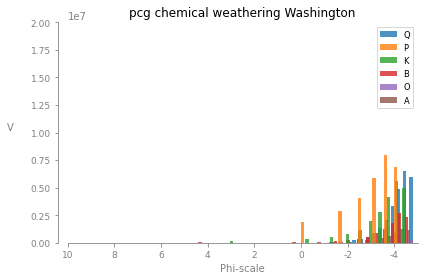

After 56 steps all pcgs have been broken down to mcg


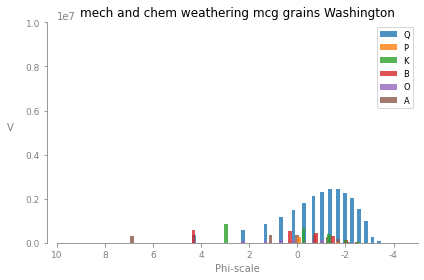

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
90/90
---SedGen model initialization finished succesfully---


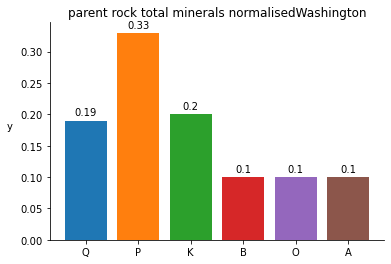

After 69 steps all pcgs have been broken down to mcg
[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


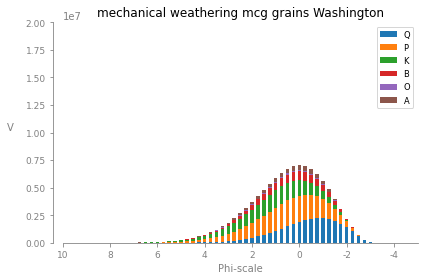

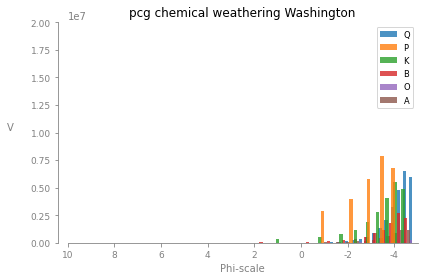

After 56 steps all pcgs have been broken down to mcg


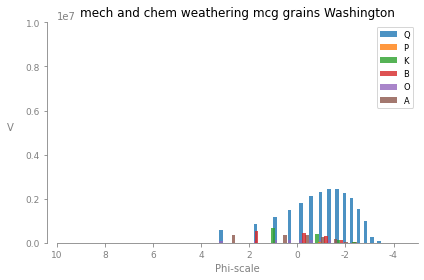

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---


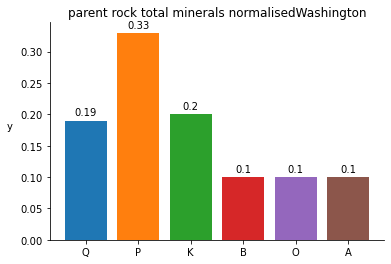

After 69 steps all pcgs have been broken down to mcg
[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


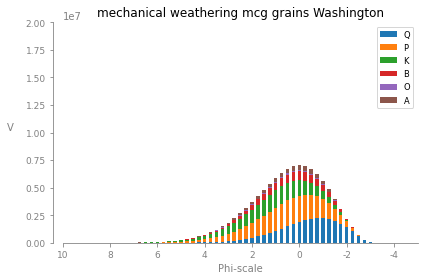

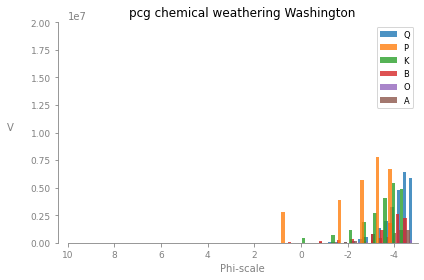

After 56 steps all pcgs have been broken down to mcg


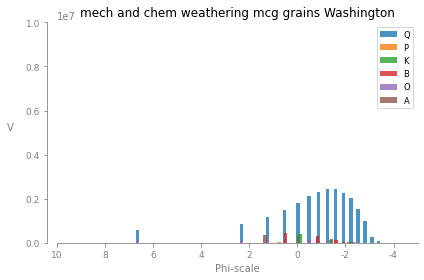

In [53]:
for i in np.arange(10,110,10):
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[2], csds_means[2], csds_stds[2],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    n_steps = i)
    name_addition = "n_steps" +str(i)
    modalminplot(pluton, sedgen, "sedgen" + name_addition)
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = i, inplace = False) 
        #plotting
    
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + name_addition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = i, inplace = False)
        #plotting
    
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + name_addition, nsteps = i - 1)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = i, inplace = False)

    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition, nsteps = i-1)